# Gmail Explorer v2

###### By [nickesc](https://github.com/nickesc) / [N. Escobar](https://nickesc.com)

Welcome back to Gmail Explorer, where last time, we used the Gmail API to grab a list of every email I've ever received, sift throught them, patching up some missing data and pruning things we didn't want. Then, we spent some time visualizing our preliminary data and analyzing what we saw. We're going to expand on that here, and look more closely at some of the trends we saw, while at the same time exploring some avenues we didn't get to go down in the last part. For a more comprehensive description of the dataset, please refer to [the](https://github.com/nickesc/Gmail-Explorer-Reader) [other](https://github.com/nickesc/Gmail-Explorer-Imputer) [parts](https://github.com/nickesc/Gmail-Explorer-Visualizer).

I wasn't really interested in using Machine Learning in this project. I really don't care for ML, it gives me a bad feeling in the pit of my stomach, and I found very little value in it. I don't want to engage with that technology if I can avoid it. I also wasn't interested much in making predictions, what fun is predicting if a message is going to be spam? I was much more interested in continuing to look at various trends and email history and over time, and just having fun finding out more information about my email use and inbox through analysis of the data, which is what I spent the bulk of my time on.

First things first, let's get our imports and notebook formatting stuff out of the way:

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import base64
import datetime
import sklearn

from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC


%matplotlib inline
from matplotlib import rcParams
import matplotlib_inline.backend_inline
from IPython.display import clear_output, display
pd.set_option('max_columns', None)
rcParams['figure.figsize'] = 10,10
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

Next, we load in our data. 

In [ ]:
emails = pd.read_csv("../Midterm/imputer/imputed/recieved.csv", index_col=[0])

There's a few transformations we're going to make to the dataset here:

In [ ]:
def getJG(string):
    if (string == "josephgoodman85@gmail.com"):
        return 1
    else:
        return 0


def getGD(string):
    if (string == "nickesc.gd@gmail.com"):
        return 1
    else:
        return 0


def getNE(string):
    if (string == "nescobar@oxy.edu"):
        return 1
    else:
        return 0


def getNM(string):
    if (string == "nickesc.media@gmail.com"):
        return 1
    else:
        return 0

First, we'll grab categorical columns for our four email addresses, 
- `JG`: `josephgoodman85@gmail.com` 
- `GD`: `nickesc.gd@gmail.com`
- `NE`: `nescobar@oxy.edu`
- `NM`: `nescobar@oxy.edu`

In [ ]:
def getThread(Id, threadId):
    if (Id != threadId):
        return 1
    else:
        return 0


def getUpdates(string):
    if ("CATEGORY_UPDATES" in string):
        return 1
    else:
        return 0


def getPersonal(string):
    if ("CATEGORY_PERSONAL" in string):
        return 1
    else:
        return 0


def getPromotions(string):
    if ("CATEGORY_PROMOTIONS" in string):
        return 1
    else:
        return 0


def getSocial(string):
    if ("CATEGORY_SOCIAL" in string):
        return 1
    else:
        return 0


def getForums(string):
    if ("CATEGORY_FORUMS" in string):
        return 1
    else:
        return 0


def getStarred(string):
    if ("STARRED" in string):
        return 1
    else:
        return 0


def getImportant(string):
    if ("IMPORTANT" in string):
        return 1
    else:
        return 0


def getSpam(string):
    if ("SPAM" in string):
        return 1
    else:
        return 0


def getTrash(string):
    if ("TRASH" in string):
        return 1
    else:
        return 0

Next, we'll do a similar thing for the labels; we check if the labels contain the regular strings, and assign True or False based on that. 
> Important to note is that emails can have any, all or none of these labels

In [ ]:
def getDecodeLen(string):
    try:
        decode = base64.urlsafe_b64decode(string).decode('utf-8')
    except:
        decode = ""
    return len(decode)


def getLen(string):
    return len(string)

Last, we convert our subject and body contents to their character lengths.

> My data, unmodified, is about 6 gigabytes. It's a bit of a pain to manage and load in every time, solely because the bodies and subjects of the messages are included. Without them, it's about 20 megabytes. In the next step we swap the email subject and body contents for a character count and end up with a much more manageable dataset. At the end, we export the smaller `.csv` so we don't have to spend ten-minutes loading the file in every time.

> I considered for a little while doing string analysis and some language processing on the bodies, but it's far outside my skills, and I didn't feel confident with it as I was exploring it.

In [ ]:
emails['JG'] = emails['delivered'].apply(getJG)
emails['GD'] = emails['delivered'].apply(getGD)
emails['NE'] = emails['delivered'].apply(getNE)
emails['NM'] = emails['delivered'].apply(getNM)
emails['thread'] = emails.apply(lambda x: getThread(x['id'], x['threadId']),axis=1)
emails['updates']=emails['labels'].apply(getUpdates)
emails['personal']=emails['labels'].apply(getPersonal)
emails['promotions']=emails['labels'].apply(getPromotions)
emails['social']=emails['labels'].apply(getSocial)
emails['forums']=emails['labels'].apply(getForums)
emails['spam']=emails['labels'].apply(getSpam)
emails['starred']=emails['labels'].apply(getStarred)
emails['important']=emails['labels'].apply(getImportant)
emails['trash']=emails['labels'].apply(getTrash)
emails.to_csv('messages.csv')

In [3]:
emails = pd.read_csv('messages.csv',index_col=[0])

emails

id          threadId                            from  \
0      1340953ff42a62c8  1340953ff42a62c8         accounts@mochigames.com   
1      136dc4cb8ea460d1  136dc4cb8ea460d1  pottermore@mail.pottermore.com   
2      136dc4ddab520861  136dc4ddab520861  pottermore@mail.pottermore.com   
3      136ebd147fcd9bba  136ebd147fcd9bba  pottermore@mail.pottermore.com   
4      13750efdfd5fd883  13750efdfd5fd883  pottermore@mail.pottermore.com   
...                 ...               ...                             ...   
87430  17f14a27dd9a9b7d  17f14a27dd9a9b7d     no-reply@mail.instagram.com   
87431  17f14af10caa271c  17f14af10caa271c                noreply@uber.com   
87432  17f1575c1426497e  17f1575c1426497e          noreply@redditmail.com   
87433  17f15a705a5f7989  17f15a705a5f7989                noreply@uber.com   
87434  17f15ab170b8f99e  17f15a705a5f7989                noreply@uber.com   

                       delivered                         to   internalDate  \
0      josephgoodman85@gmail.com  josephgoodman85@gmail.com  1323006426000   
1      josephgoodman85@gmail.com  josephgoodman85@gmail.com  1335135875000   
2      josephgoodman85@gmail.com  josephgoodman85@gmail.com  1335135950000   
3      josephgoodman85@gmail.com  josephgoodman85@gmail.com  1335396221000   
4      josephgoodman85@gmail.com  josephgoodman85@gmail.com  1337092709000   
...                          ...                        ...            ...   
87430  josephgoodman85@gmail.com  josephgoodman85@gmail.com  1645318654000   
87431       nickesc.gd@gmail.com       nickesc.gd@gmail.com  1645319490000   
87432  josephgoodman85@gmail.com  josephgoodman85@gmail.com  1645332512000   
87433       nickesc.gd@gmail.com       nickesc.gd@gmail.com  1645335740000   
87434       nickesc.gd@gmail.com       nickesc.gd@gmail.com  1645336007000   

                  dateTime  year  month  day  \
0      2011-12-04 08:47:06  2011     12    4   
1      2012-04-22 19:04:35  2012      4   22   
2      2012-04-22 19:05:50  2012      4   22   
3      2012-04-25 19:23:41  2012      4   25   
4      2012-05-15 10:38:29  2012      5   15   
...                    ...   ...    ...  ...   
87430  2022-02-19 19:57:34  2022      2   19   
87431  2022-02-19 20:11:30  2022      2   19   
87432  2022-02-19 23:48:32  2022      2   19   
87433  2022-02-20 00:42:20  2022      2   20   
87434  2022-02-20 00:46:47  2022      2   20   

                                           labels  sizeEstimate  subject  \
0                            ['CATEGORY_UPDATES']          7036       35   
1                            ['CATEGORY_UPDATES']         11169       23   
2                         ['CATEGORY_PROMOTIONS']          9236       50   
3                            ['CATEGORY_UPDATES']          9724       26   
4                         ['CATEGORY_PROMOTIONS']         33234       52   
...                                           ...           ...      ...   
87430      ['UNREAD', 'CATEGORY_SOCIAL', 'INBOX']         26182       58   
87431  ['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']        126617       34   
87432  ['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']        103349       49   
87433     ['UNREAD', 'CATEGORY_UPDATES', 'INBOX']         83724       42   
87434    ['UNREAD', 'CATEGORY_PERSONAL', 'INBOX']         90516       42   

         body  JG  GD  NE  NM  thread  updates  personal  promotions  social  \
0         787   1   0   0   0       0        1         0           0       0   
1        8516   1   0   0   0       0        1         0           0       0   
2        6671   1   0   0   0       0        0         0           1       0   
3        6992   1   0   0   0       0        1         0           0       0   
4        2318   1   0   0   0       0        0         0           1       0   
...       ...  ..  ..  ..  ..     ...      ...       ...         ...     ...   
87430   19858   1   0   0   0       0        0         0           0       1   
87431  113185   0   1   0   0

And once we finally have that file loaded into the notebook, we'll convert our dateTime string to a datetime object, since it can't be stored like that in the `.csv`. We'll also make sure we're only looking at emails sent to one of those four addresses instead of any other that might be floating in the set (there are a few random ones), and we drop about 500 rows cluttering the data.

Finally, we create a clean, new dataframe with all the message data.

In [4]:
emails['date'] = emails.apply(lambda row: datetime.datetime(row['year'], row['month'], row['day']), axis=1)

emails = emails[(emails['delivered'] == "josephgoodman85@gmail.com") 
                | (emails['delivered'] == "nickesc.gd@gmail.com") 
                | (emails['delivered'] == "nescobar@oxy.edu") 
                | (emails['delivered'] == "nickesc.media@gmail.com")]

messages = emails[['delivered','from','to','id','threadId','internalDate','date', 'sizeEstimate','body','subject','year','month','day', 'JG', 'GD', 'NE', 'NM','updates','personal','promotions', 'social','forums','spam','starred','important','trash','thread']]

In [5]:
print('Message Data')
display(messages)
display(messages.info())
messages.describe()

Message Data


delivered                            from  \
0      josephgoodman85@gmail.com         accounts@mochigames.com   
1      josephgoodman85@gmail.com  pottermore@mail.pottermore.com   
2      josephgoodman85@gmail.com  pottermore@mail.pottermore.com   
3      josephgoodman85@gmail.com  pottermore@mail.pottermore.com   
4      josephgoodman85@gmail.com  pottermore@mail.pottermore.com   
...                          ...                             ...   
87430  josephgoodman85@gmail.com     no-reply@mail.instagram.com   
87431       nickesc.gd@gmail.com                noreply@uber.com   
87432  josephgoodman85@gmail.com          noreply@redditmail.com   
87433       nickesc.gd@gmail.com                noreply@uber.com   
87434       nickesc.gd@gmail.com                noreply@uber.com   

                              to                id          threadId  \
0      josephgoodman85@gmail.com  1340953ff42a62c8  1340953ff42a62c8   
1      josephgoodman85@gmail.com  136dc4cb8ea460d1  136dc4cb8ea460d1   
2      josephgoodman85@gmail.com  136dc4ddab520861  136dc4ddab520861   
3      josephgoodman85@gmail.com  136ebd147fcd9bba  136ebd147fcd9bba   
4      josephgoodman85@gmail.com  13750efdfd5fd883  13750efdfd5fd883   
...                          ...               ...               ...   
87430  josephgoodman85@gmail.com  17f14a27dd9a9b7d  17f14a27dd9a9b7d   
87431       nickesc.gd@gmail.com  17f14af10caa271c  17f14af10caa271c   
87432  josephgoodman85@gmail.com  17f1575c1426497e  17f1575c1426497e   
87433       nickesc.gd@gmail.com  17f15a705a5f7989  17f15a705a5f7989   
87434       nickesc.gd@gmail.com  17f15ab170b8f99e  17f15a705a5f7989   

        internalDate       date  sizeEstimate    body  subject  year  month  \
0      1323006426000 2011-12-04          7036     787       35  2011     12   
1      1335135875000 2012-04-22         11169    8516       23  2012      4   
2      1335135950000 2012-04-22          9236    6671       50  2012      4   
3      1335396221000 2012-04-25          9724    6992       26  2012      4   
4      1337092709000 2012-05-15         33234    2318       52  2012      5   
...              ...        ...           ...     ...      ...   ...    ...   
87430  1645318654000 2022-02-19         26182   19858       58  2022      2   
87431  1645319490000 2022-02-19        126617  113185       34  2022      2   
87432  1645332512000 2022-02-19        103349   98530       49  2022      2   
87433  1645335740000 2022-02-20         83724   72543       42  2022      2   
87434  1645336007000 2022-02-20         90516   78840       42  2022      2   

       day  JG  GD  NE  NM  updates  personal  promotions  social  forums  \
0        4   1   0   0   0        1         0           0       0       0   
1       22   1   0   0   0        1         0           0       0       0   
2       22   1   0   0   0        0         0           1       0       0   
3       25   1   0   0   0        1         0           0       0       0   
4       15   1   0   0   0        0         0           1       0       0   
...    ...  ..  ..  ..  ..      ...       ...         ...     ...     ...   
87430   19   1   0   0   0        0         0           0       1       0   
87431   19   0   1   0   0        0         0           1       0       0   
87432   19   1   0   0   0        0         0           1       0       0   
87433   20   0   1   0   0        1         0           0       0       0   
87434   20   0   1   0   0        0         1           0       0       0   

       spam  starred  important  trash  thread  
0         0        0          0      0       0  
1         0        0          0      0       0  
2         0        0          0      0       0  
3         0        0          0      0       0  
4         0        0          0      0       0  
...     ...      ...        ...    ...     ...  
87430     0        0          0      0       0  
87431     0        0          0      0       0  
87432     0        0      

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87058 entries, 0 to 87434
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   delivered     87058 non-null  object        
 1   from          87058 non-null  object        
 2   to            87058 non-null  object        
 3   id            87058 non-null  object        
 4   threadId      87058 non-null  object        
 5   internalDate  87058 non-null  int64         
 6   date          87058 non-null  datetime64[ns]
 7   sizeEstimate  87058 non-null  int64         
 8   body          87058 non-null  int64         
 9   subject       87058 non-null  int64         
 10  year          87058 non-null  int64         
 11  month         87058 non-null  int64         
 12  day           87058 non-null  int64         
 13  JG            87058 non-null  int64         
 14  GD            87058 non-null  int64         
 15  NE            87058 non-null  int64 

None

internalDate  sizeEstimate           body       subject          year  \
count  8.705800e+04  8.705800e+04   87058.000000  87058.000000  87058.000000   
mean   1.570797e+12  1.778440e+05   33774.826805     53.039881   2019.254681   
std    4.870390e+10  9.095976e+05   46966.224846     28.495979      1.574619   
min    1.323006e+12  1.765000e+03       0.000000      3.000000   2011.000000   
25%    1.539665e+12  3.020900e+04    1243.000000     34.000000   2018.000000   
50%    1.575595e+12  5.956950e+04   11301.000000     47.000000   2019.000000   
75%    1.610269e+12  1.005670e+05   54269.000000     63.000000   2021.000000   
max    1.645336e+12  3.577005e+07  791185.000000    315.000000   2022.000000   

              month          day            JG            GD            NE  \
count  87058.000000  87058.00000  87058.000000  87058.000000  87058.000000   
mean       6.763342     15.82012      0.383733      0.426968      0.187829   
std        3.587439      8.81753      0.486297      0.494640      0.390578   
min        1.000000      1.00000      0.000000      0.000000      0.000000   
25%        4.000000      8.00000      0.000000      0.000000      0.000000   
50%        7.000000     16.00000      0.000000      0.000000      0.000000   
75%       10.000000     23.00000      1.000000      1.000000      0.000000   
max       12.000000     31.00000      1.000000      1.000000      1.000000   

                 NM       updates      personal    promotions        social  \
count  87058.000000  87058.000000  87058.000000  87058.000000  87058.000000   
mean       0.001470      0.227791      0.039008      0.557456      0.056089   
std        0.038316      0.419409      0.193616      0.496691      0.230095   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      1.000000      0.000000   
75%        0.000000      0.000000      0.000000      1.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             forums          spam       starred     important    trash  \
count  87058.000000  87058.000000  87058.000000  87058.000000  87058.0   
mean       0.119564      0.000896      0.001057      0.179754      0.0   
std        0.324453      0.029919      0.032491      0.383984      0.0   
min        0.000000      0.000000      0.000000      0.000000      0.0   
25%        0.000000      0.000000      0.000000      0.000000      0.0   
50%        0.000000      0.000000      0.000000      0.000000      0.0   
75%        0.000000      0.000000      0.000000      0.000000      0.0   
max        1.000000      1.000000      1.000000      1.000000      0.0   

             thread  
count  87058.000000  
mean       0.031910  
std        0.175761  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

Let's get this out of the way first:

This is a huge pairplot! It graphs everything -- to be perfectly honest, it's kind of awful to look at but I really like it, which is why I want to start with it. This is the continuation of the last pairplot graphs from the last part, but here we can also look at how all of our new columns fit into it. It's a little rough to look at, and the boolean columns really don't tell us too much from here, especially in terms of our color-coded plot, but it's a good starting point to get an idea of the data.

In [ ]:
sns.pairplot(messages, hue='delivered')

PairPlot of all numeric values
[![hugePairPlot](img/hugePairPlot.png)](https://google.com)

Click the image to view it in a new tab.

## Exploring our data more closely

We're looking at twenty-seven columns in our DataFrame:

- `id`: the ID for the email, it is discrete and unique for each email. It is only useful in combination with `threadId`, because if `id`==`threadId`, the email is a part of a thread, and if `id`!=`threadId`, it is not. Used to determine `thread`. String.
- `threadId`: the ID for the thread the email is in. If the email is not part of a thread, `threadId`==`id`. It is discrete, but not necessarily unique, as emails can be from the same thread. String.
- `internalDate`: int, this is the Epoch time (in milliseconds) that the email was received. It is continuous and non-unique. Used to determine `year`, `month` and `day`. Int.
- `sizeEstimate`: the size estimate for the email. Discrete and non-unique. Int.
- `body`: the character length of the email body. I've been using this instead of the email bodies themselves, as they take up far too much memory. Int.
- `subject`: the character length of the email subject. I've been using this instead of the email subjects themselves, as they take up far too much memory. Int.
- `delivered`: the address the email was delivered to. One of the four addresses we're exploring. Some spam emails come with addresses spoofing my own and were dropped. String.
- `from`: the sender of the email. String.
- `to`: the address the sender typed in to send the email. Could be one of the four addresses we're exploring or something like a mailing list's address. String.
- `date`: the day the email was sent on. `datetime` object between Dec. 4 2011 and Feb. 20 2022
- `year`: the year the email was sent in. Int between 2011 and 2022.
- `month`: the month the email was sent in. Between 1 and 12.
- `day`: the day of the month the email was sent on. Int between 1 and 31.
- `JG`: whether the email was delivered to *josephgoodman85@gmail.com*. 0 or 1.
- `GD`: whether the email was delivered to *nickesc.gd@gmail.com*. 0 or 1.
- `NE`: whether the email was delivered to *nescobar@oxy.edu*. 0 or 1.
- `NM`: whether the email was delivered to *nickesc.media@gmail.com*. 0 or 1.
- `updates`: whether the email had the *CATEGORY_UPDATES* tag. 0 or 1.
- `personal`: whether the email had the *CATEGORY_PERSONAL* tag. 0 or 1.
- `promotions`: whether the email had the *CATEGORY_PROMOTIONS* tag. 0 or 1.
- `social`: whether the email had the *CATEGORY_SOCIAL* tag. 0 or 1.
- `forums`: whether the email had the *CATEGORY_FORUMS* tag. 0 or 1.
- `spam`: whether the email had the *SPAM* tag. 0 or 1.
- `starred`: whether the email had the *STARRED* tag. 0 or 1.
- `important`: whether the email had the *IMPORTANT* tag. 0 or 1.
- `trash`: whether the email had the *TRASH* tag. 0 or 1.
- `thread`: whether the email was part of a thread. 0 or 1.

This should look familiar again, it's the distribution for our messages over time. We wont spend too long on this, as we've seen it and covered it in depth [before](https://github.com/nickesc/Gmail-Explorer-Visualizer). What we should remember though is the swap from `JG` as the primary address to `GD` and addition of `NE`, my school email about a year later.

> Important to note is that these are graphed over time instead of internalDate now. It makes it much clearer what we're actually looking at.

I also want to point out what happened sometime in 2018 - I was really curious about this dip in `JG`, it goes way down briefly and the corrects itself. And it's right around the introduction of two emails; it's a lot more noticeable on the histogram than the KDE graph, and we'll look closer at that period in a second, because there was a significant drop in use. Let's see if we can piece something together from the coincidental knowledge I have of the history of my own life.

I'm also interested in the pattern we see in `NE`, with consistent dips and rises, which I guessed were from the summer, but I want to be sure of that. We're also going to look at NM on its own, since its hard to get any idea of it when it's mixed in with the others.

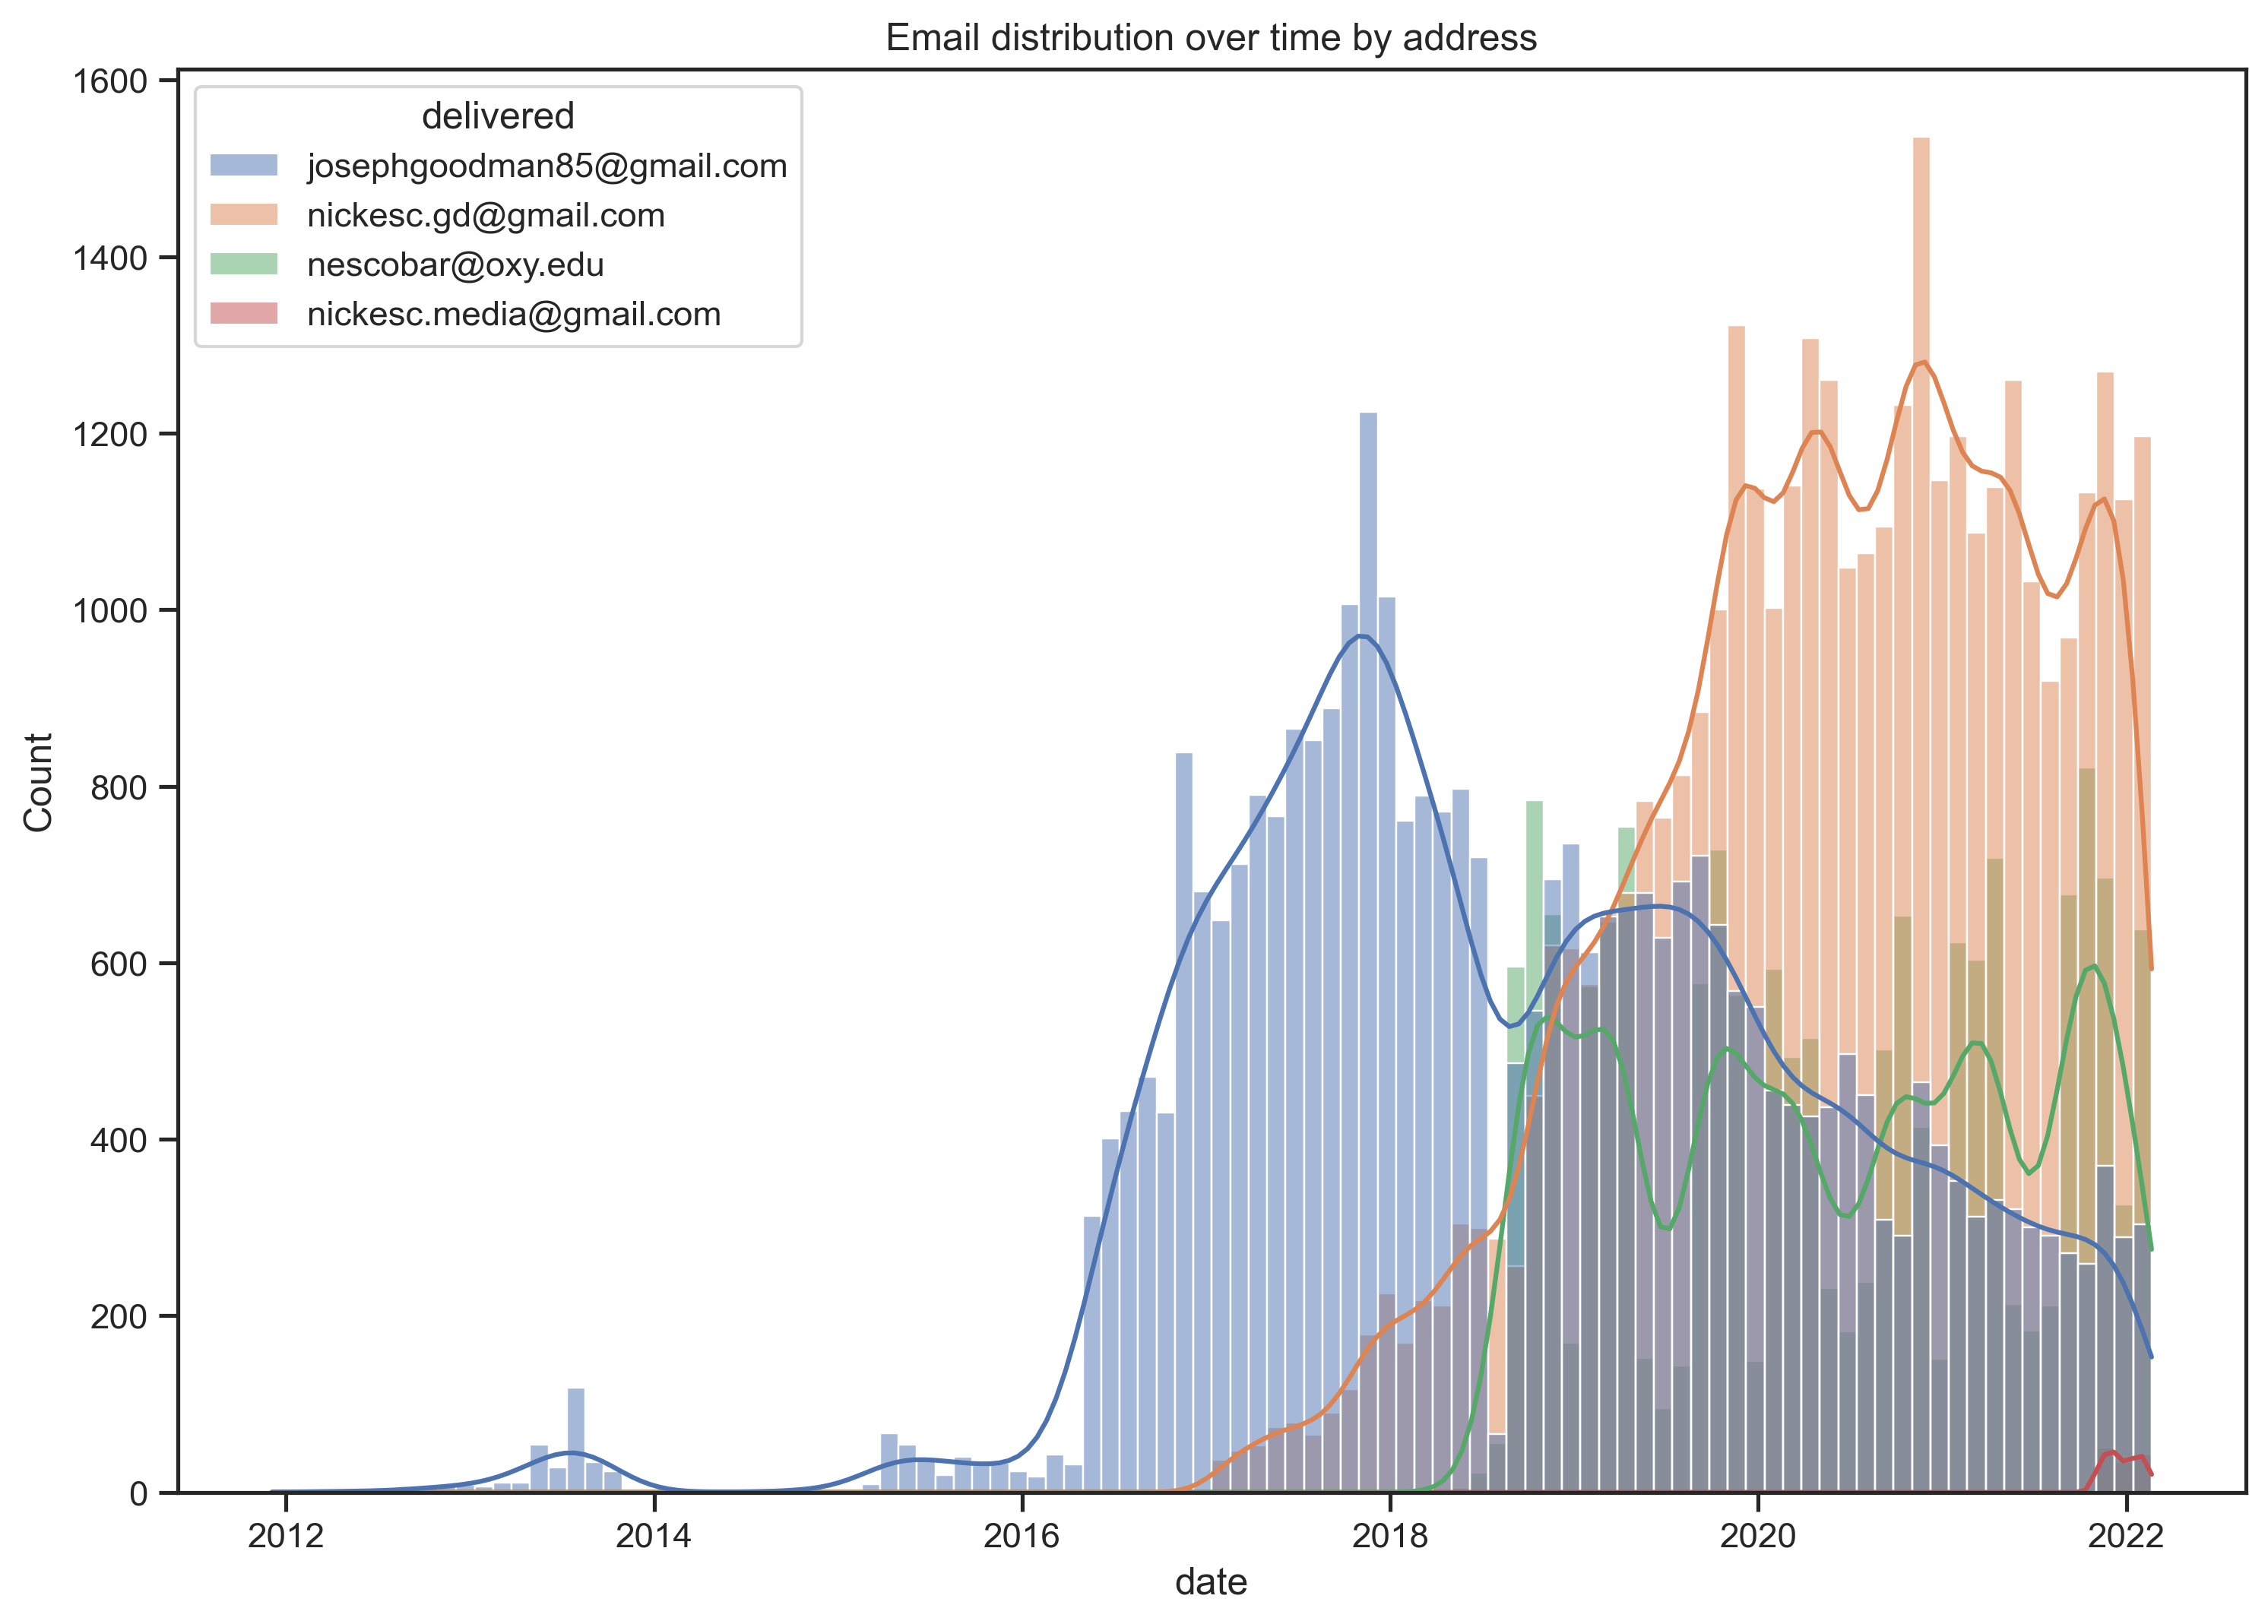

<Figure size 4500x2400 with 0 Axes>

In [6]:
sns.histplot(data=messages,x="date", hue = 'delivered', kde=True).set(title = 'Email distribution over time by address')
plt.figure(figsize = (15,8))
plt.show()

A new, but very similar graph, is the ECDF plot below. This tells us the proportion of each inbox received over time. This one was really interesting to me as I looked at the behavior of the three dominant addresses. I describe it as a "swap" of the addresses before, but I hadn't realized how apt a description that was yet. In this graph, we can see an almost exact inversion of `JG` to `GD`, while `NE` parallels `GD` almost exactly, despite being introduced much later.

We can equate these lines to inbox use over time -- and we can see clearly the behavior we described in the first version of this project, how `JG` has leveled off while `GD` and `NE` have increased exponentially. This makes a lot of sense, given the events in the world at the time -- I made a new email address with the intent of making it my main one, and it's taken about five years but `JG`'s use has finally started to crest, as the swap is nearing completion -- which, again, tracks, as I barely use that email anymore, I never sign up with it and have swapped all other accounts off of it to `GD`.

`NE`'s behavior I can't really explain. I don't know how it parallels `GD` so well, given they're completely independent and receive very different emails. My hypothesis is that the lack of school emails in the summer creates the plateau you can see on the plot, which offset it just enough to make it non-linear and in line with the exponential growth of `GD`.

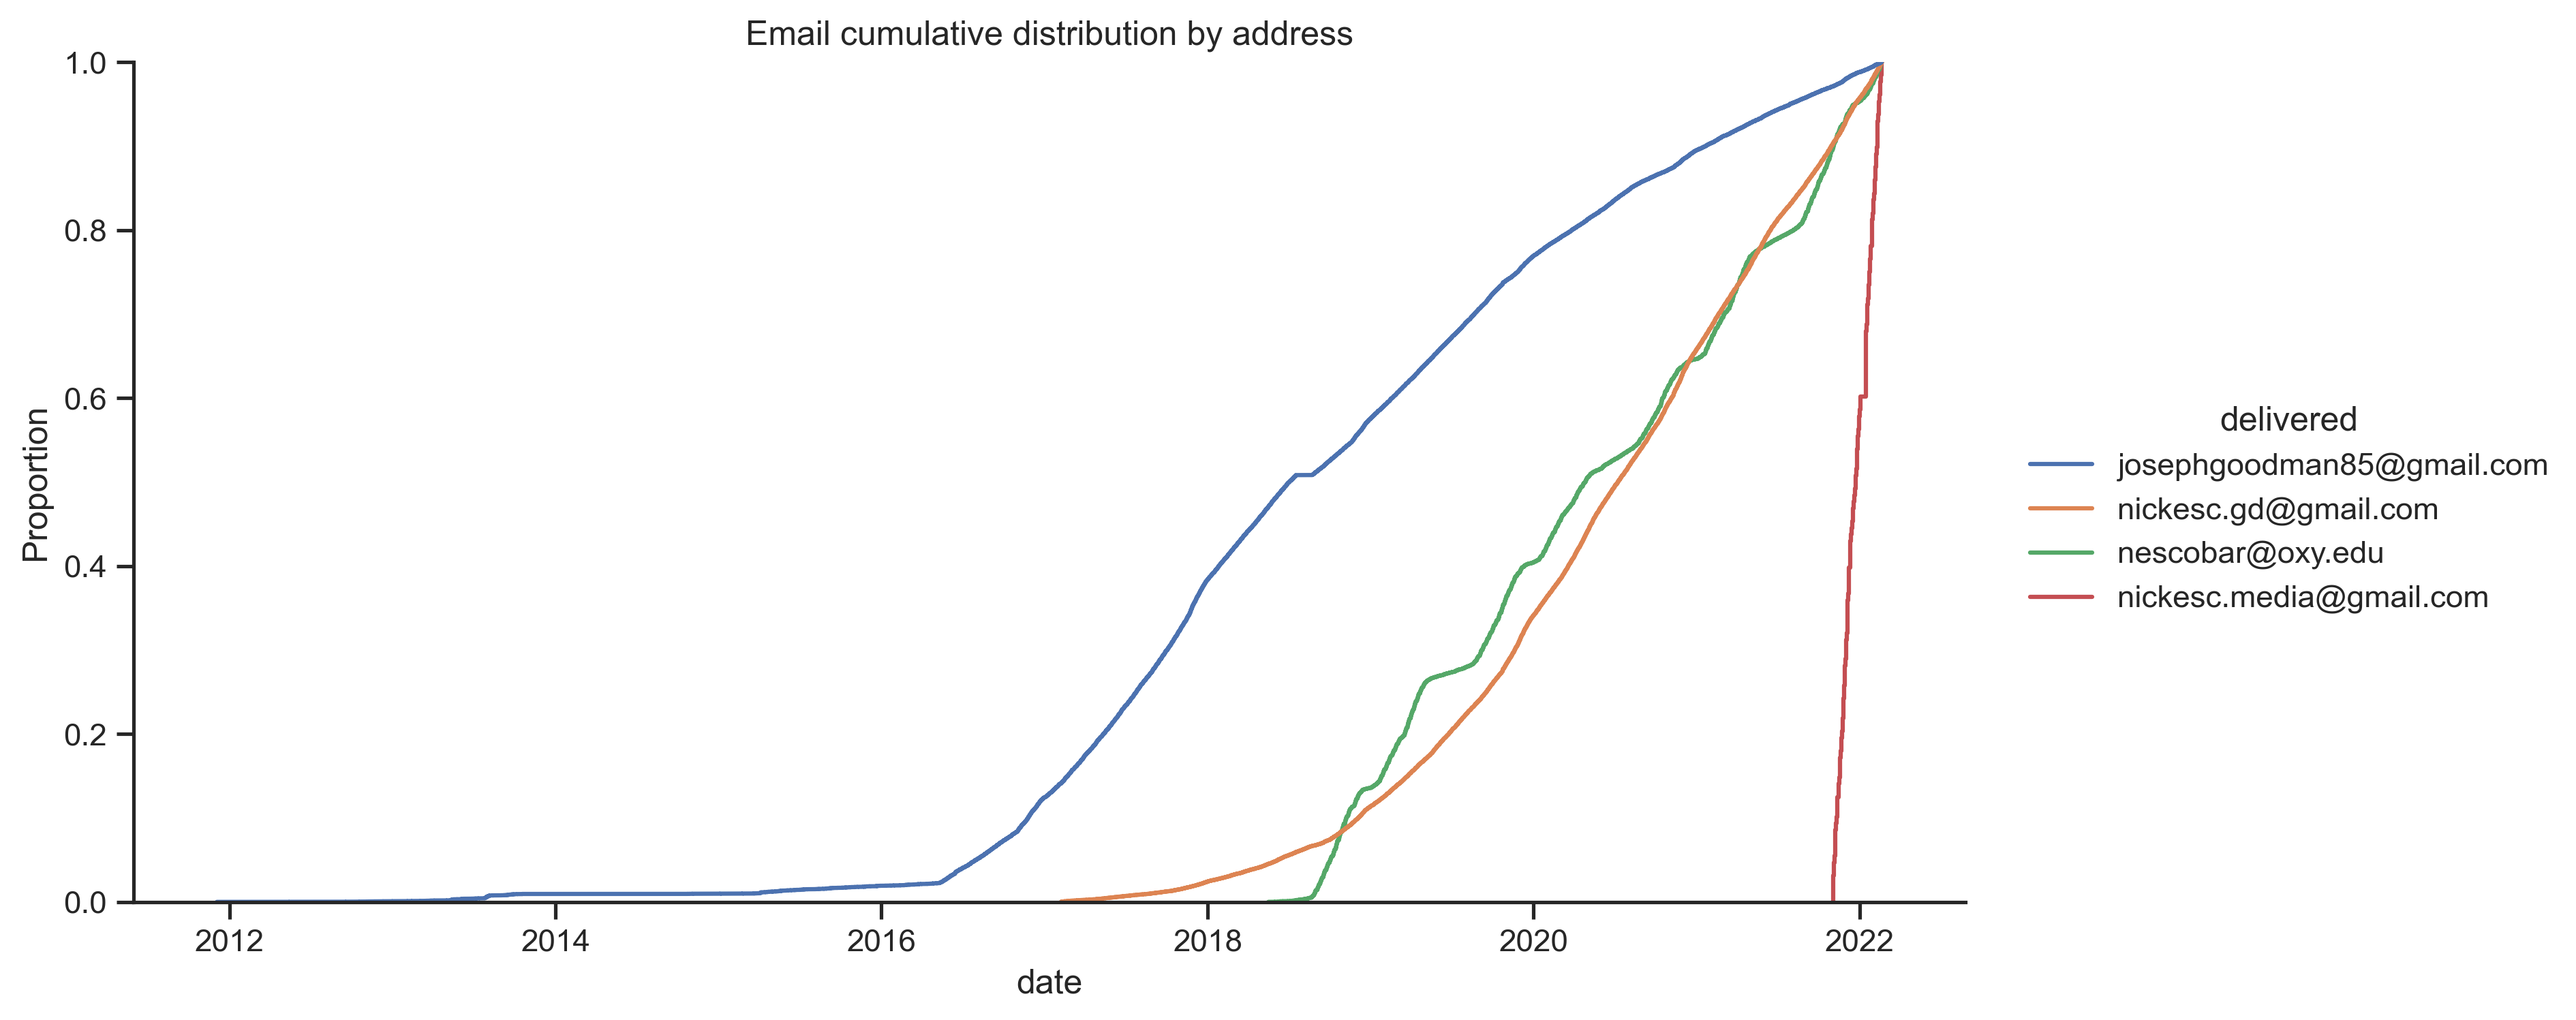

In [7]:
sns.displot(data=messages, x='date', hue='delivered', kind='ecdf', height=5, aspect=2).set(title = 'Email cumulative distribution by address')

Again, we can point out the weird behavior in 2018 with the next two graphs:

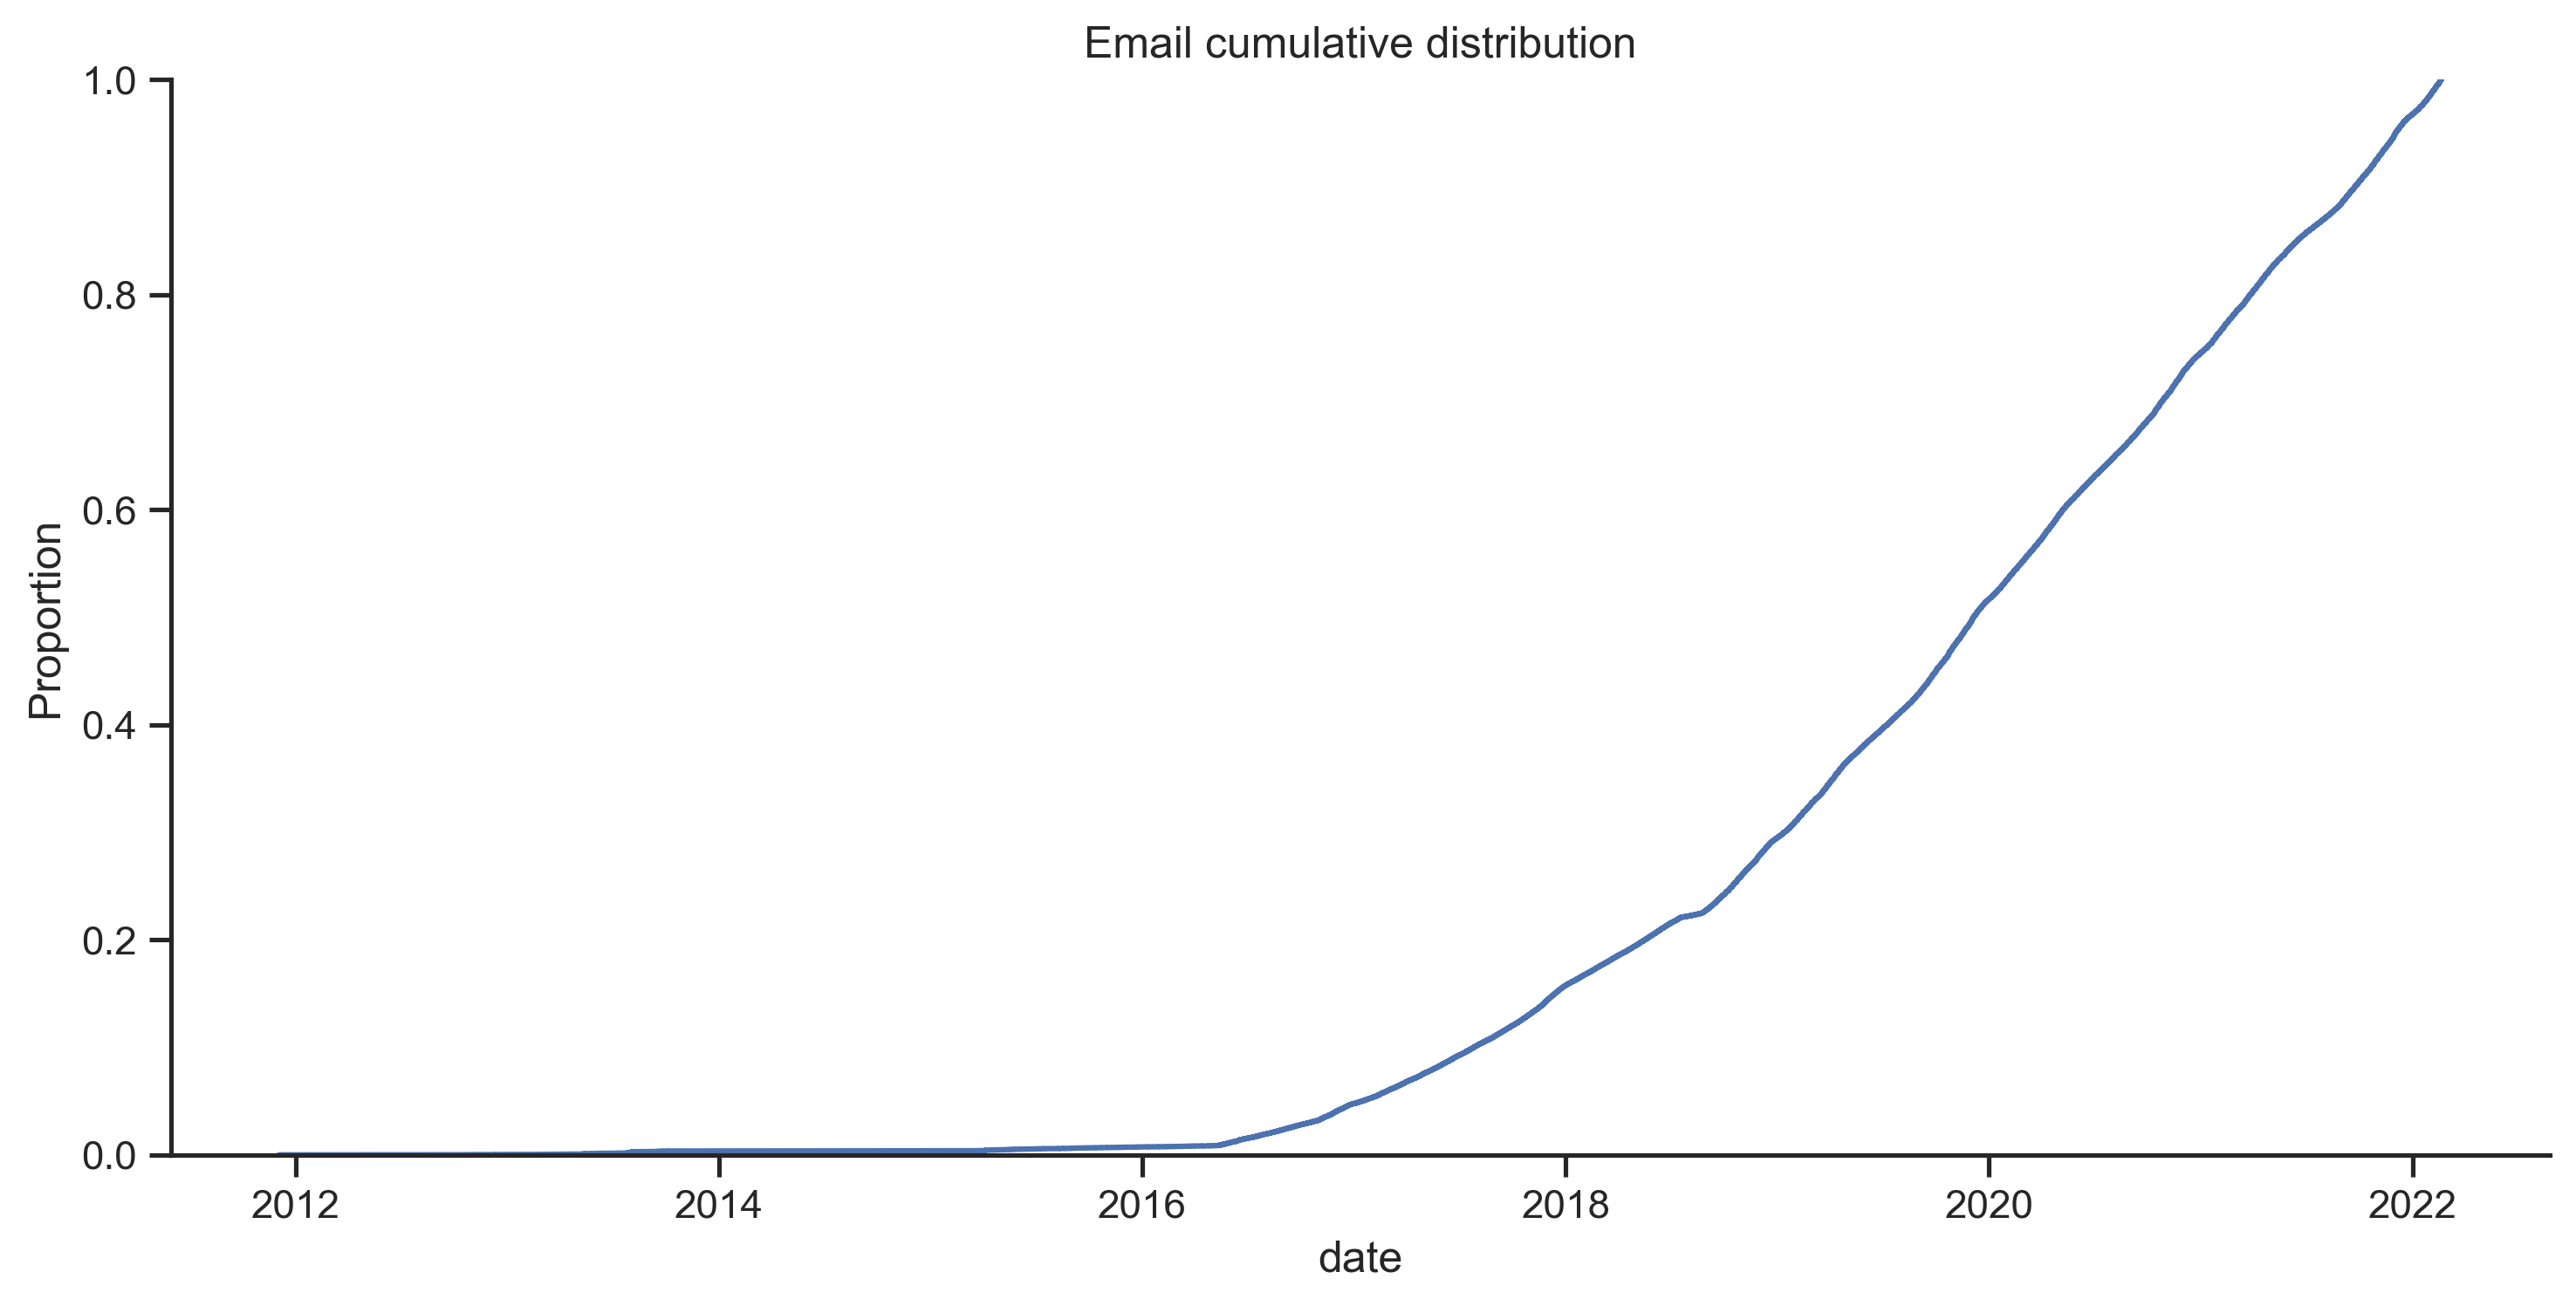

In [8]:
sns.displot(data=messages, x='date', kind='ecdf', height=5, aspect=2).set(title = 'Email cumulative distribution')

plt.show()

Here we see what we would expect given the shape of the other ECDF graphs.

But if we look a little closer, we can point out only two events visible on this graph: when I started to use `JG` for more than just a fake Facebook account. In 2016, you see a sharp increase, which you would expect from the email going from being used to unused. The only other event we can see, however, isn't the introduction of one of the other three emails -- it's the dip from `JG` in 2018.

The same phenonmenon can be seen on the next graph. Once my inbox starts getting consistent use in 2016, it's a linear relationship for the most part, with emails being weighted slightly more heavily towards the end of the year. *Except in 2018.* We again see the dip reflected, the only thing like it.

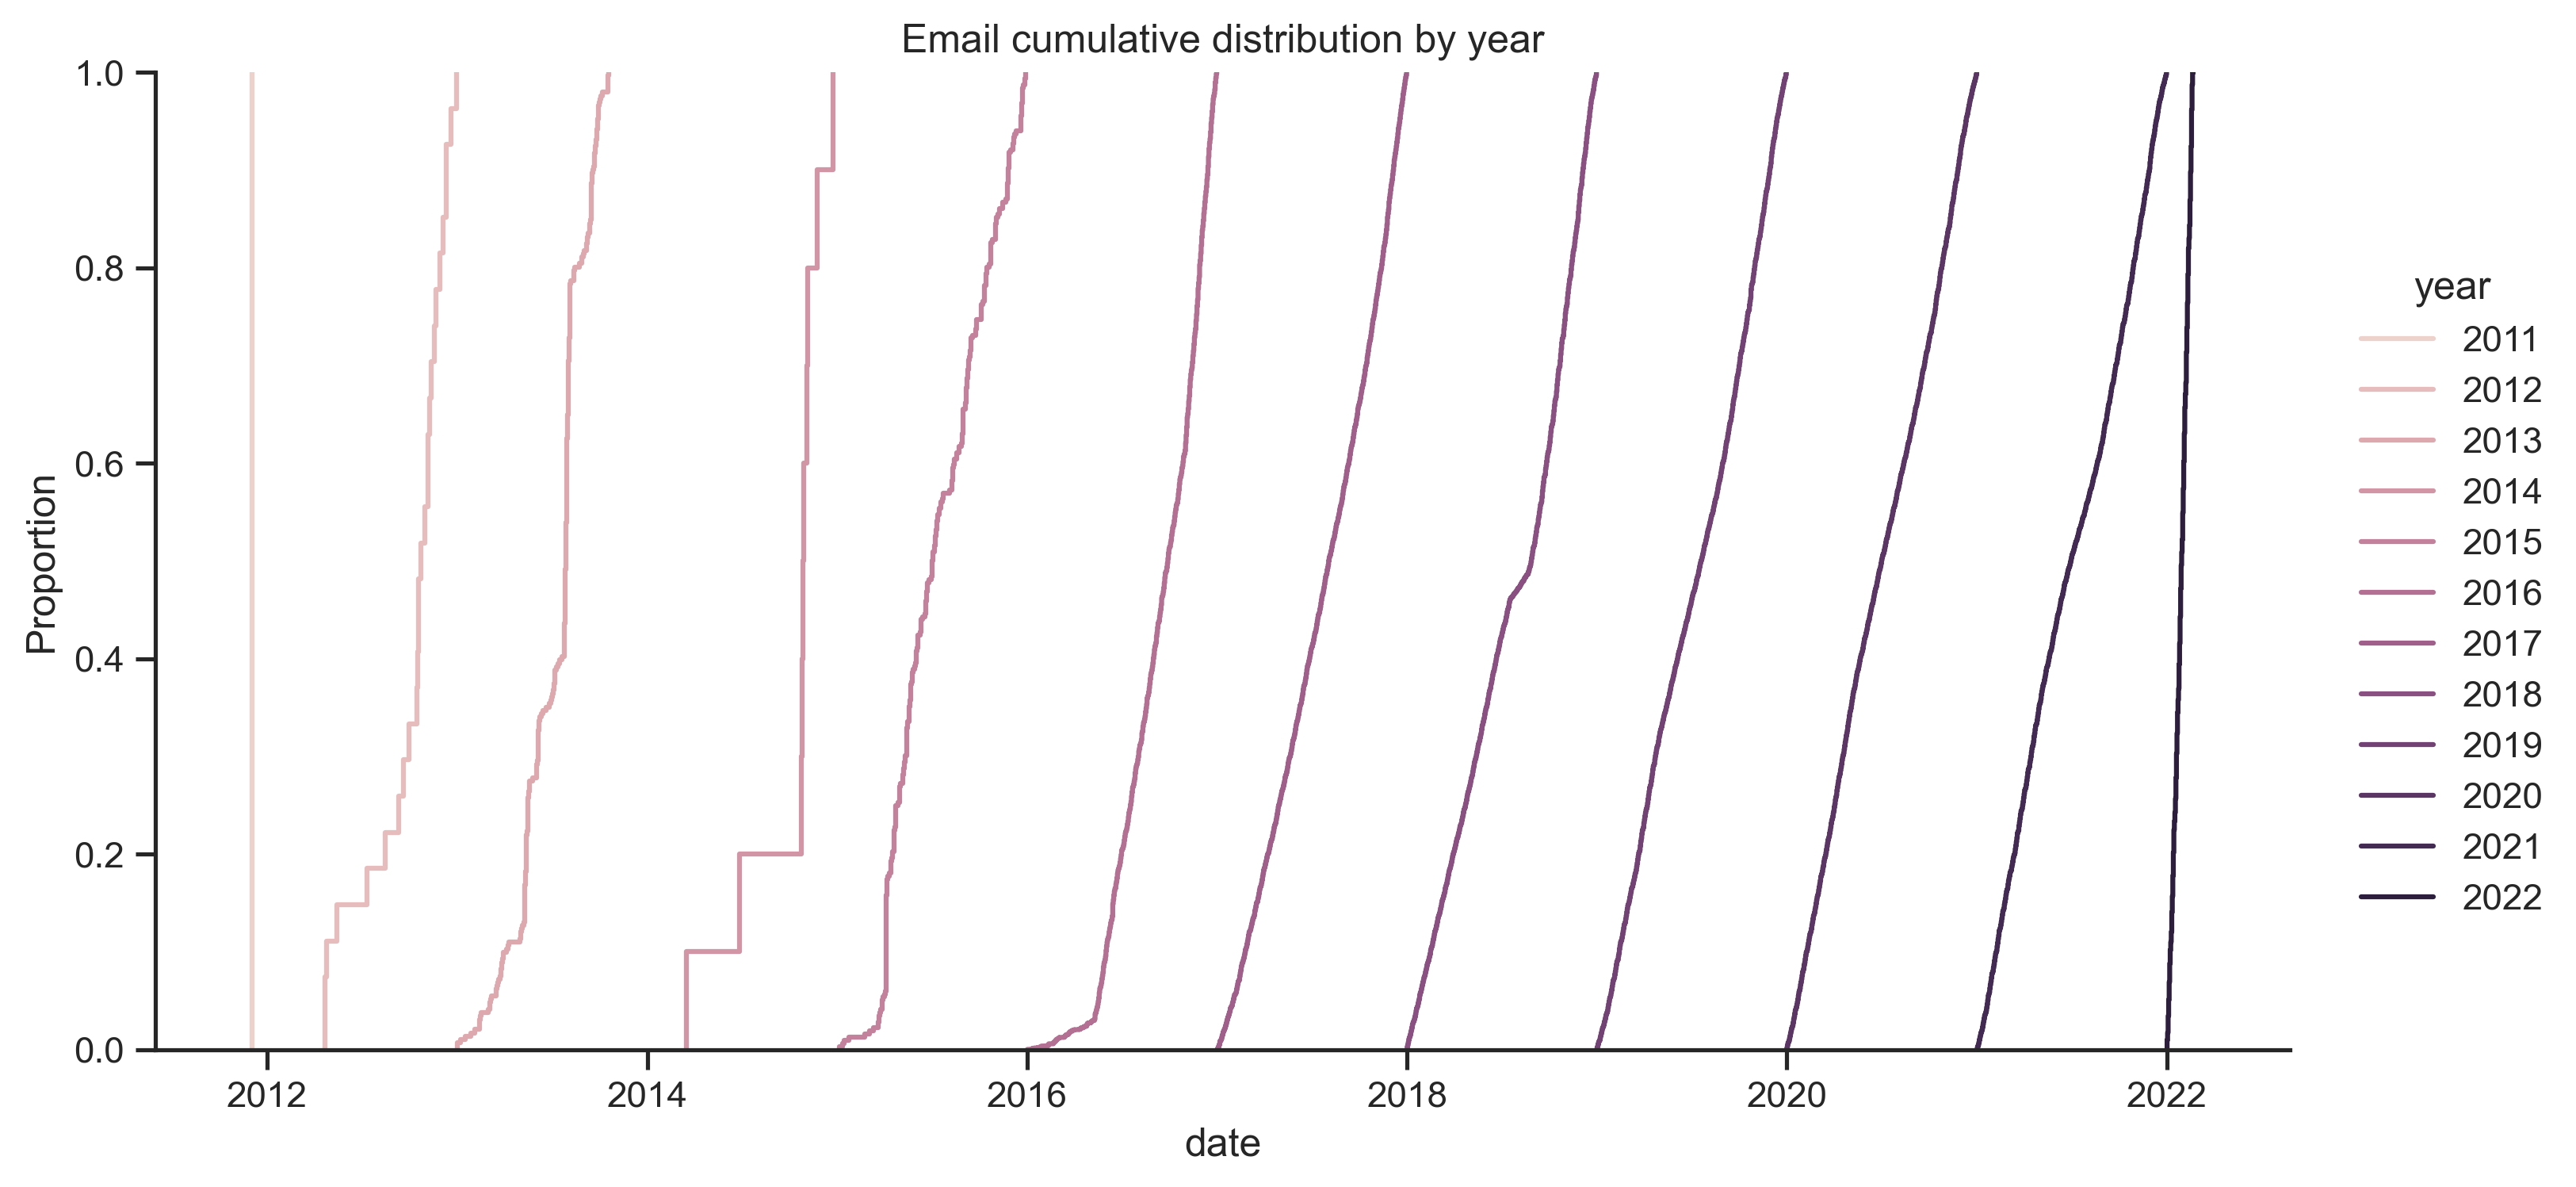

In [9]:
sns.displot(data=messages, x='date', hue='year', kind='ecdf', height=5, aspect=2).set(title = 'Email cumulative distribution by year')
plt.show()

Finally, let's look at that period:

[Text(0.5, 1.0, 'Summer 2018 email distribution')]

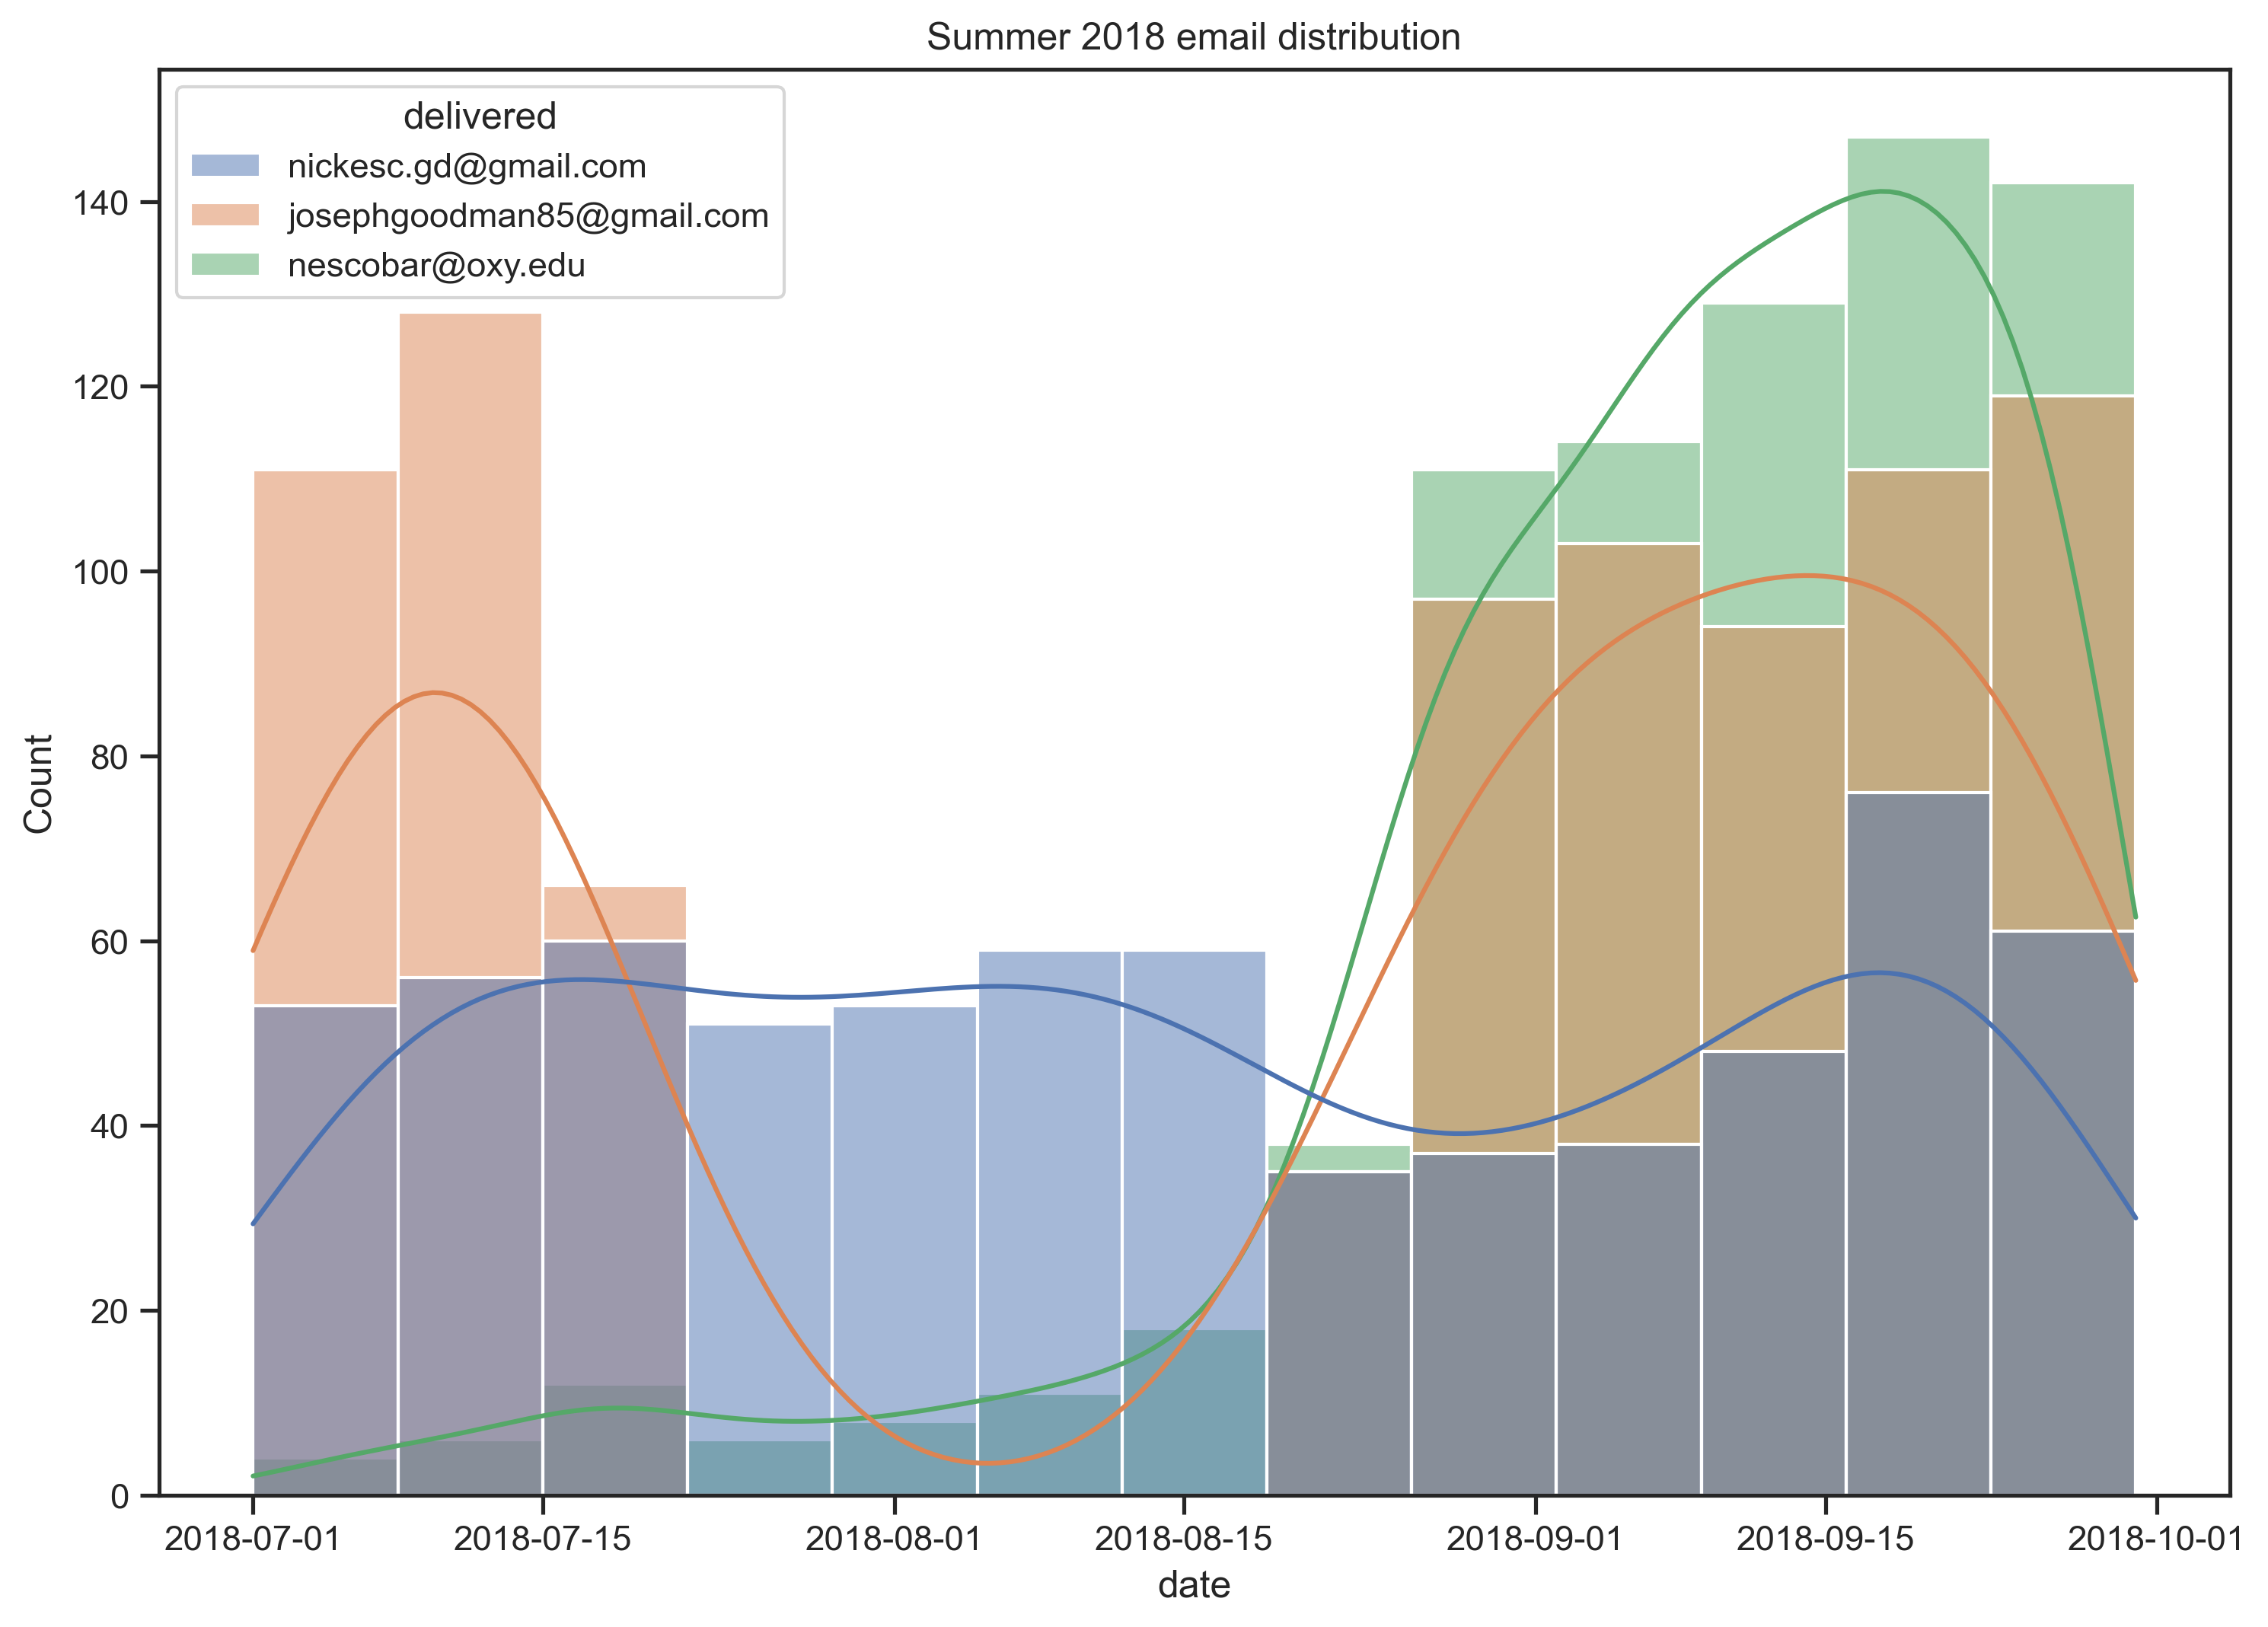

In [10]:
eighteen = messages[messages['year']==2018]
#eighteen['date'] = eighteen['date'].to_datetime(df['date'])

#hue_order = ['josephgoodman85@gmail.com','nickesc.gd@gmail.com','nescobar@oxy.edu','nickesc.media@gmail.com']

se = eighteen[eighteen['month']==7]
ei = eighteen[eighteen['month']==8]
ni = eighteen[eighteen['month']==9]
two = pd.concat([se,ei])
three = pd.concat([two,ni])

sns.histplot(data=three,x="date", hue = 'delivered', kde=True).set(title = 'Summer 2018 email distribution')

I won't lie, I was confused by this. Despite that encyclopedic knowledge of my life, I really don't understand how it's possible I got 0 emails to `JG` for an entire month. I can only see two ways this is possible:
1. I permanently deleted all of those emails and *just* those emails. I know I didn't drop them while imputing or when I dropped the extra addresses.
> These extra addresses are just from spam emails spoofing me I think.
2. the it's an error on Gmail's end, and they don't have a record of my emails from that month

I think it's more likely I deleted them, but I'm not sure.


Moving on, lets talk about `NE` for a little bit.

In [11]:
ne = messages[messages['NE'] == 1]
display(ne)

delivered                                       from  \
17415  nescobar@oxy.edu                    mail-noreply@google.com   
17416  nescobar@oxy.edu                    mail-noreply@google.com   
17825  nescobar@oxy.edu                        orientation@oxy.edu   
17884  nescobar@oxy.edu                        orientation@oxy.edu   
17885  nescobar@oxy.edu                          spark@readdle.com   
...                 ...                                        ...   
87411  nescobar@oxy.edu                                 ea@oxy.edu   
87417  nescobar@oxy.edu  handshake@notifications.joinhandshake.com   
87418  nescobar@oxy.edu                            barbell@oxy.edu   
87425  nescobar@oxy.edu                     periodicbaking@oxy.edu   
87427  nescobar@oxy.edu        noreply@zoommeetingsclassaction.com   

                           to                id          threadId  \
17415        nescobar@oxy.edu  1636ec418cd8d263  1636ec418cd8d263   
17416        nescobar@oxy.edu  1636ec41c1fbc7b3  1636ec41c1fbc7b3   
17825        nescobar@oxy.edu  163b347f589d649d  163b347f589d649d   
17884        nescobar@oxy.edu  163bd26d0ef3fccb  163bd26d0ef3fccb   
17885        nescobar@oxy.edu  163bd2b9d1a03a7d  163bd2b9d1a03a7d   
...                       ...               ...               ...   
87411  oxy-students-l@oxy.edu  17f1327461ed7d20  17f1327461ed7d20   
87417        nescobar@oxy.edu  17f13907296eef1b  17f13907296eef1b   
87418  oxy-students-l@oxy.edu  17f14c719ae6cf5d  17f14c719ae6cf5d   
87425  oxy-students-l@oxy.edu  17f14c71b57bbeb9  17f14c71b57bbeb9   
87427        nescobar@oxy.edu  17f143ba1af502ea  17f143ba1af502ea   

        internalDate       date  sizeEstimate   body  subject  year  month  \
17415  1526571735000 2018-05-17          4845   3853       35  2018      5   
17416  1526571736000 2018-05-17          9484   8193       29  2018      5   
17825  1527721225000 2018-05-30         19437   1929       33  2018      5   
17884  1527886824000 2018-06-01         20874  15175       34  2018      6   
17885  1527887141000 2018-06-01          9167   4677       32  2018      6   
...              ...        ...           ...    ...      ...   ...    ...   
87411  1645292496000 2022-02-19         37284    156       92  2022      2   
87417  1645300707000 2022-02-19         33168   2303       70  2022      2   
87418  1645300800000 2022-02-19         10211    156       92  2022      2   
87425  1645310352000 2022-02-19        277702    156       58  2022      2   
87427  1645311925000 2022-02-19         35991  21769       40  2022      2   

       day  JG  GD  NE  NM  updates  personal  promotions  social  forums  \
17415   17   0   0   1   0        0         0           0       0       0   
17416   17   0   0   1   0        0         0           0       0       0   
17825   30   0   0   1   0        0         1           0       0       0   
17884    1   0   0   1   0        0         1           0       0       0   
17885    1   0   0   1   0        1         0           0       0       0   
...    ...  ..  ..  ..  ..      ...       ...         ...     ...     ...   
87411   19   0   0   1   0        0         0           0       0       1   
87417   19   0   0   1   0        1         0           0       0       0   
87418   19   0   0   1   0        0         0           0       0       1   
87425   19   0   0   1   0        0         0           0       0       1   
87427   19   0   0   1   0        0         0           1       0       0   

       spam  starred  important  trash  thread  
17415     0        0          0      0       0  
17416     0        0          0      0       0  
17825     0        0          0      0       0  
17884     0        0          0      0       0  
17885     0        0          1      0       0  
...     ...      ...        ...    ...     ...  
87411     0        0          0      0       0  
87417     0        0          1      0       0  
87418     0        0          0      0   

`NE` has about sixteen-thousand rows, but from our distribution plot above, we know that there's a pattern to the emails on that account. Let's look at it by itself.

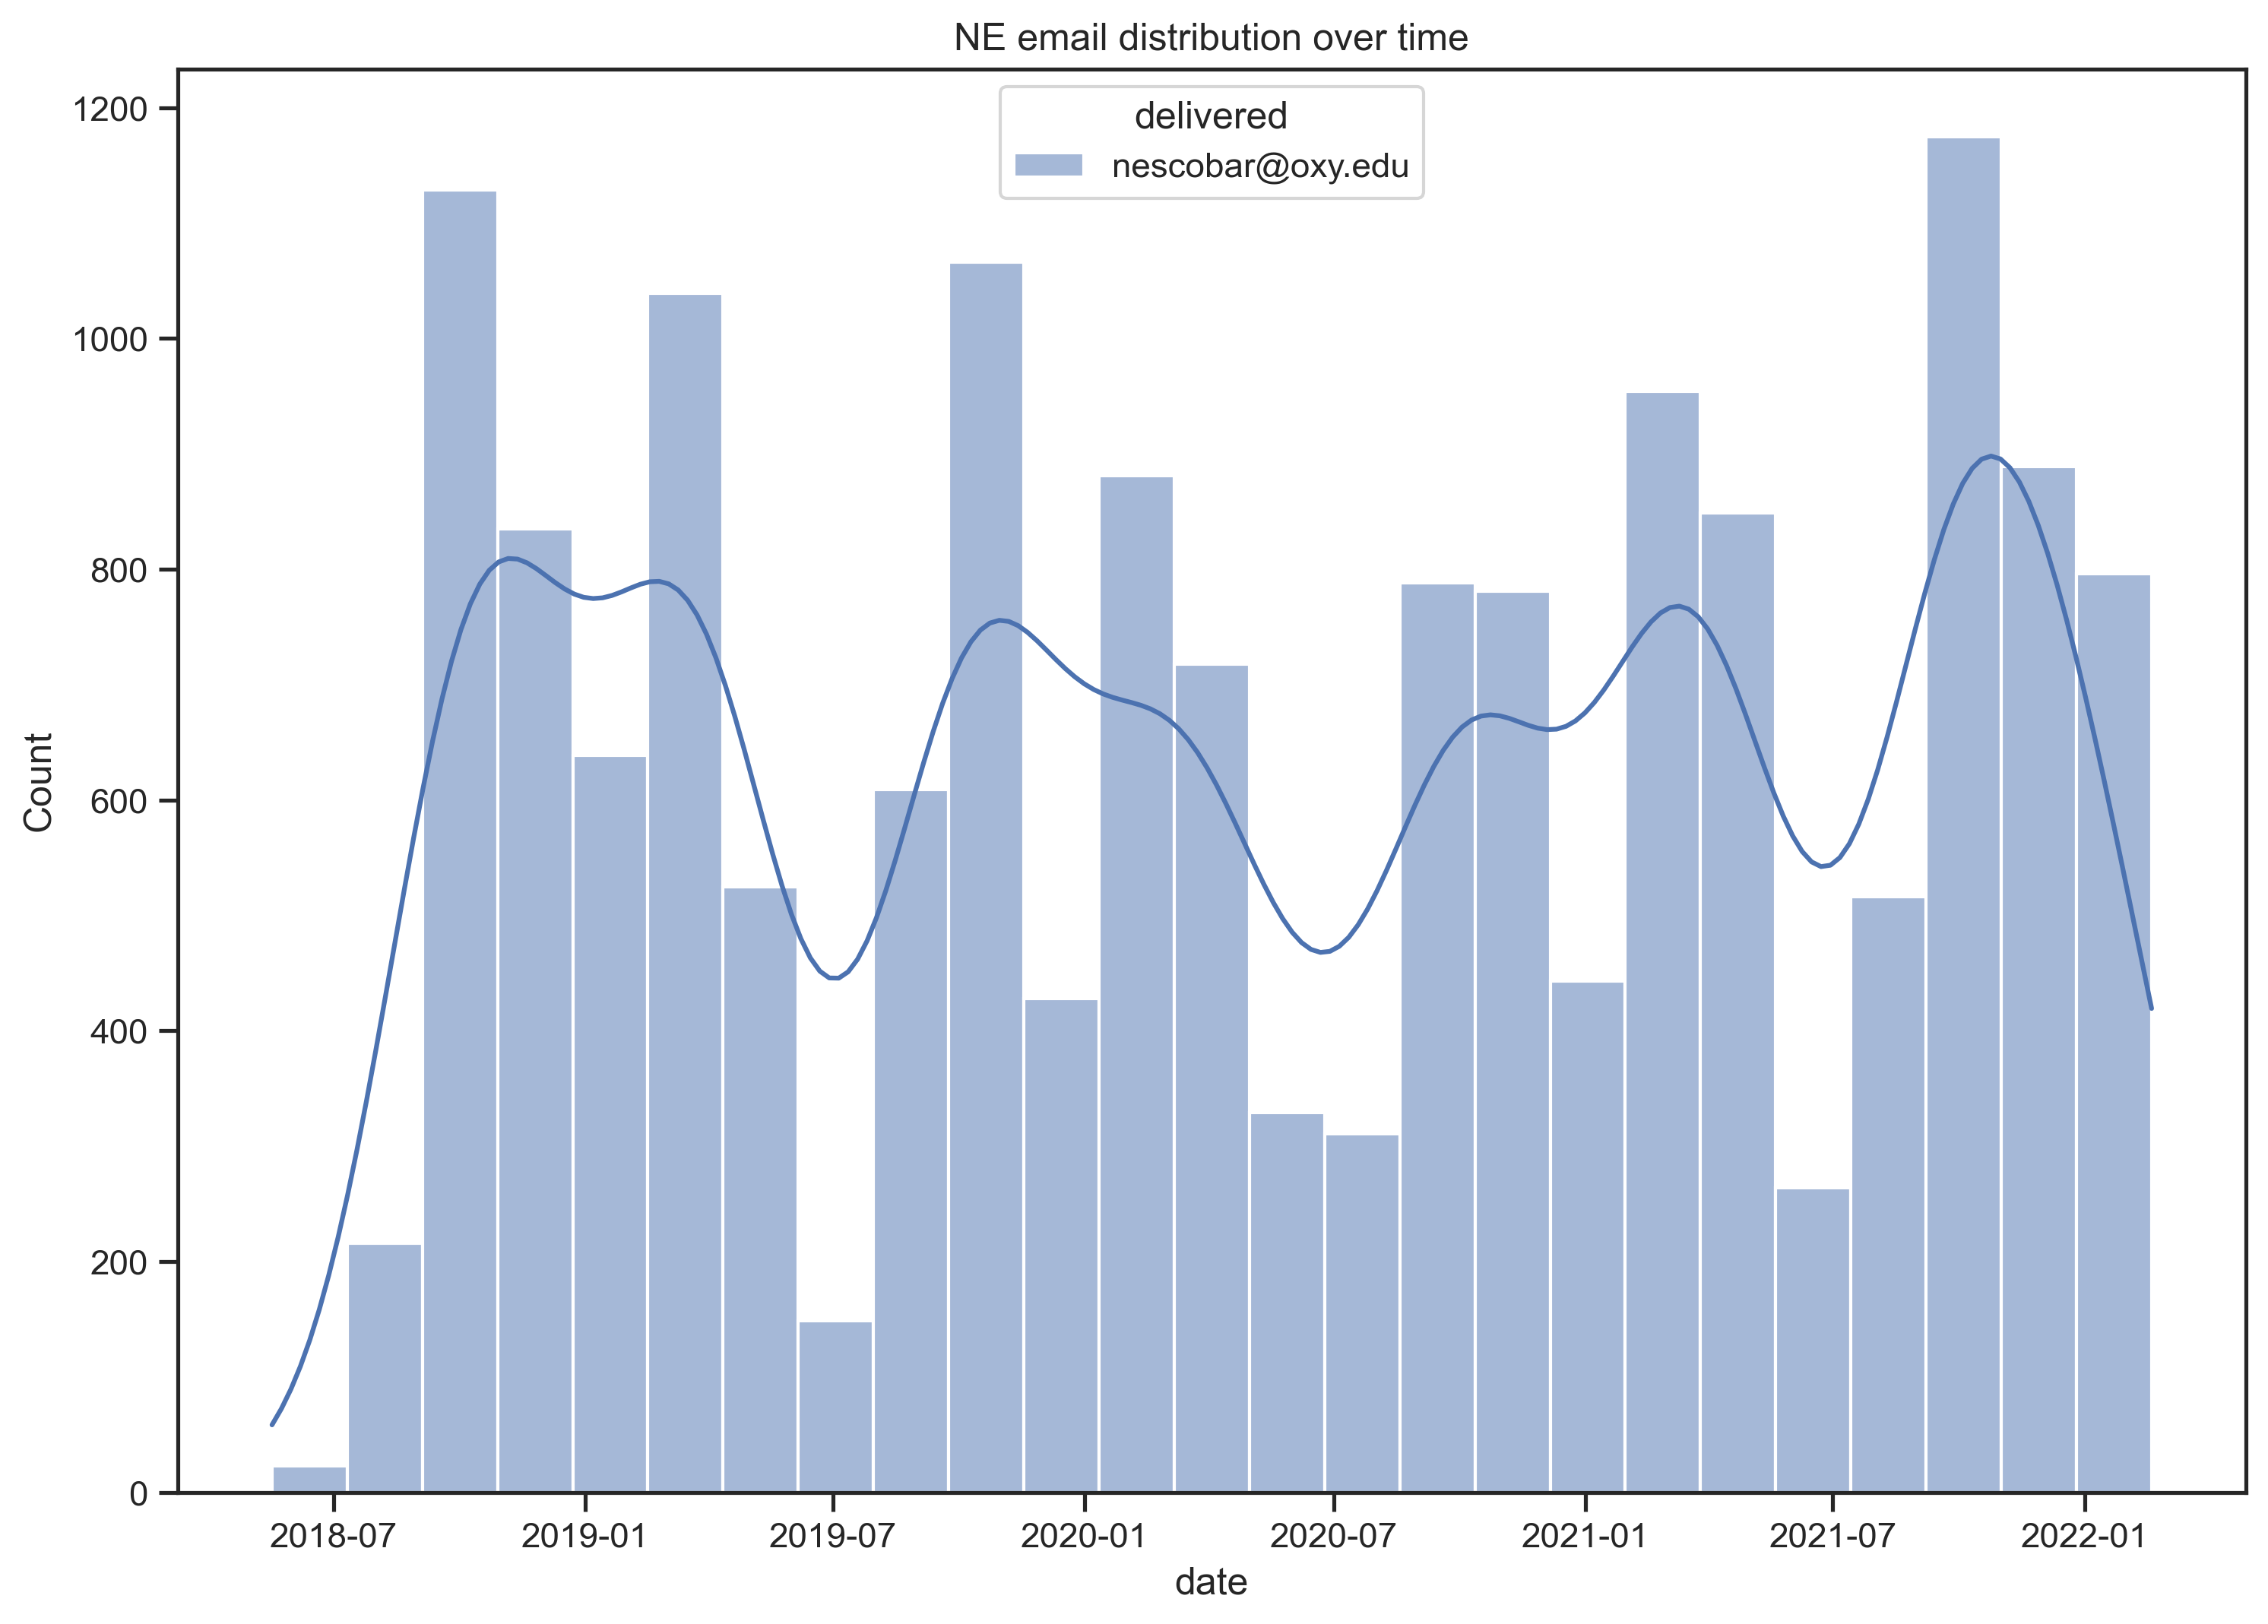

In [12]:
sns.histplot(data=ne,x="date", hue = 'delivered', kde=True).set(title = 'NE email distribution over time')
plt.show()

With a closer look we can definitely tell that the pattern dips in the summer. This is, presumabley, because Oxy mostly stops sending me emails over the summer, so whatever is left should be non-Oxy emails. We should be able to filter those out but excluding any row with a `from` address with `oxy.edu`, which should hopefully leave us with an even distribution of emails through the year.

In [13]:
nonOxy = ne[~ne['from'].str.contains('oxy.edu')].copy(deep=True)
oxy = ne[ne['from'].str.contains('oxy.edu')].copy(deep=True)

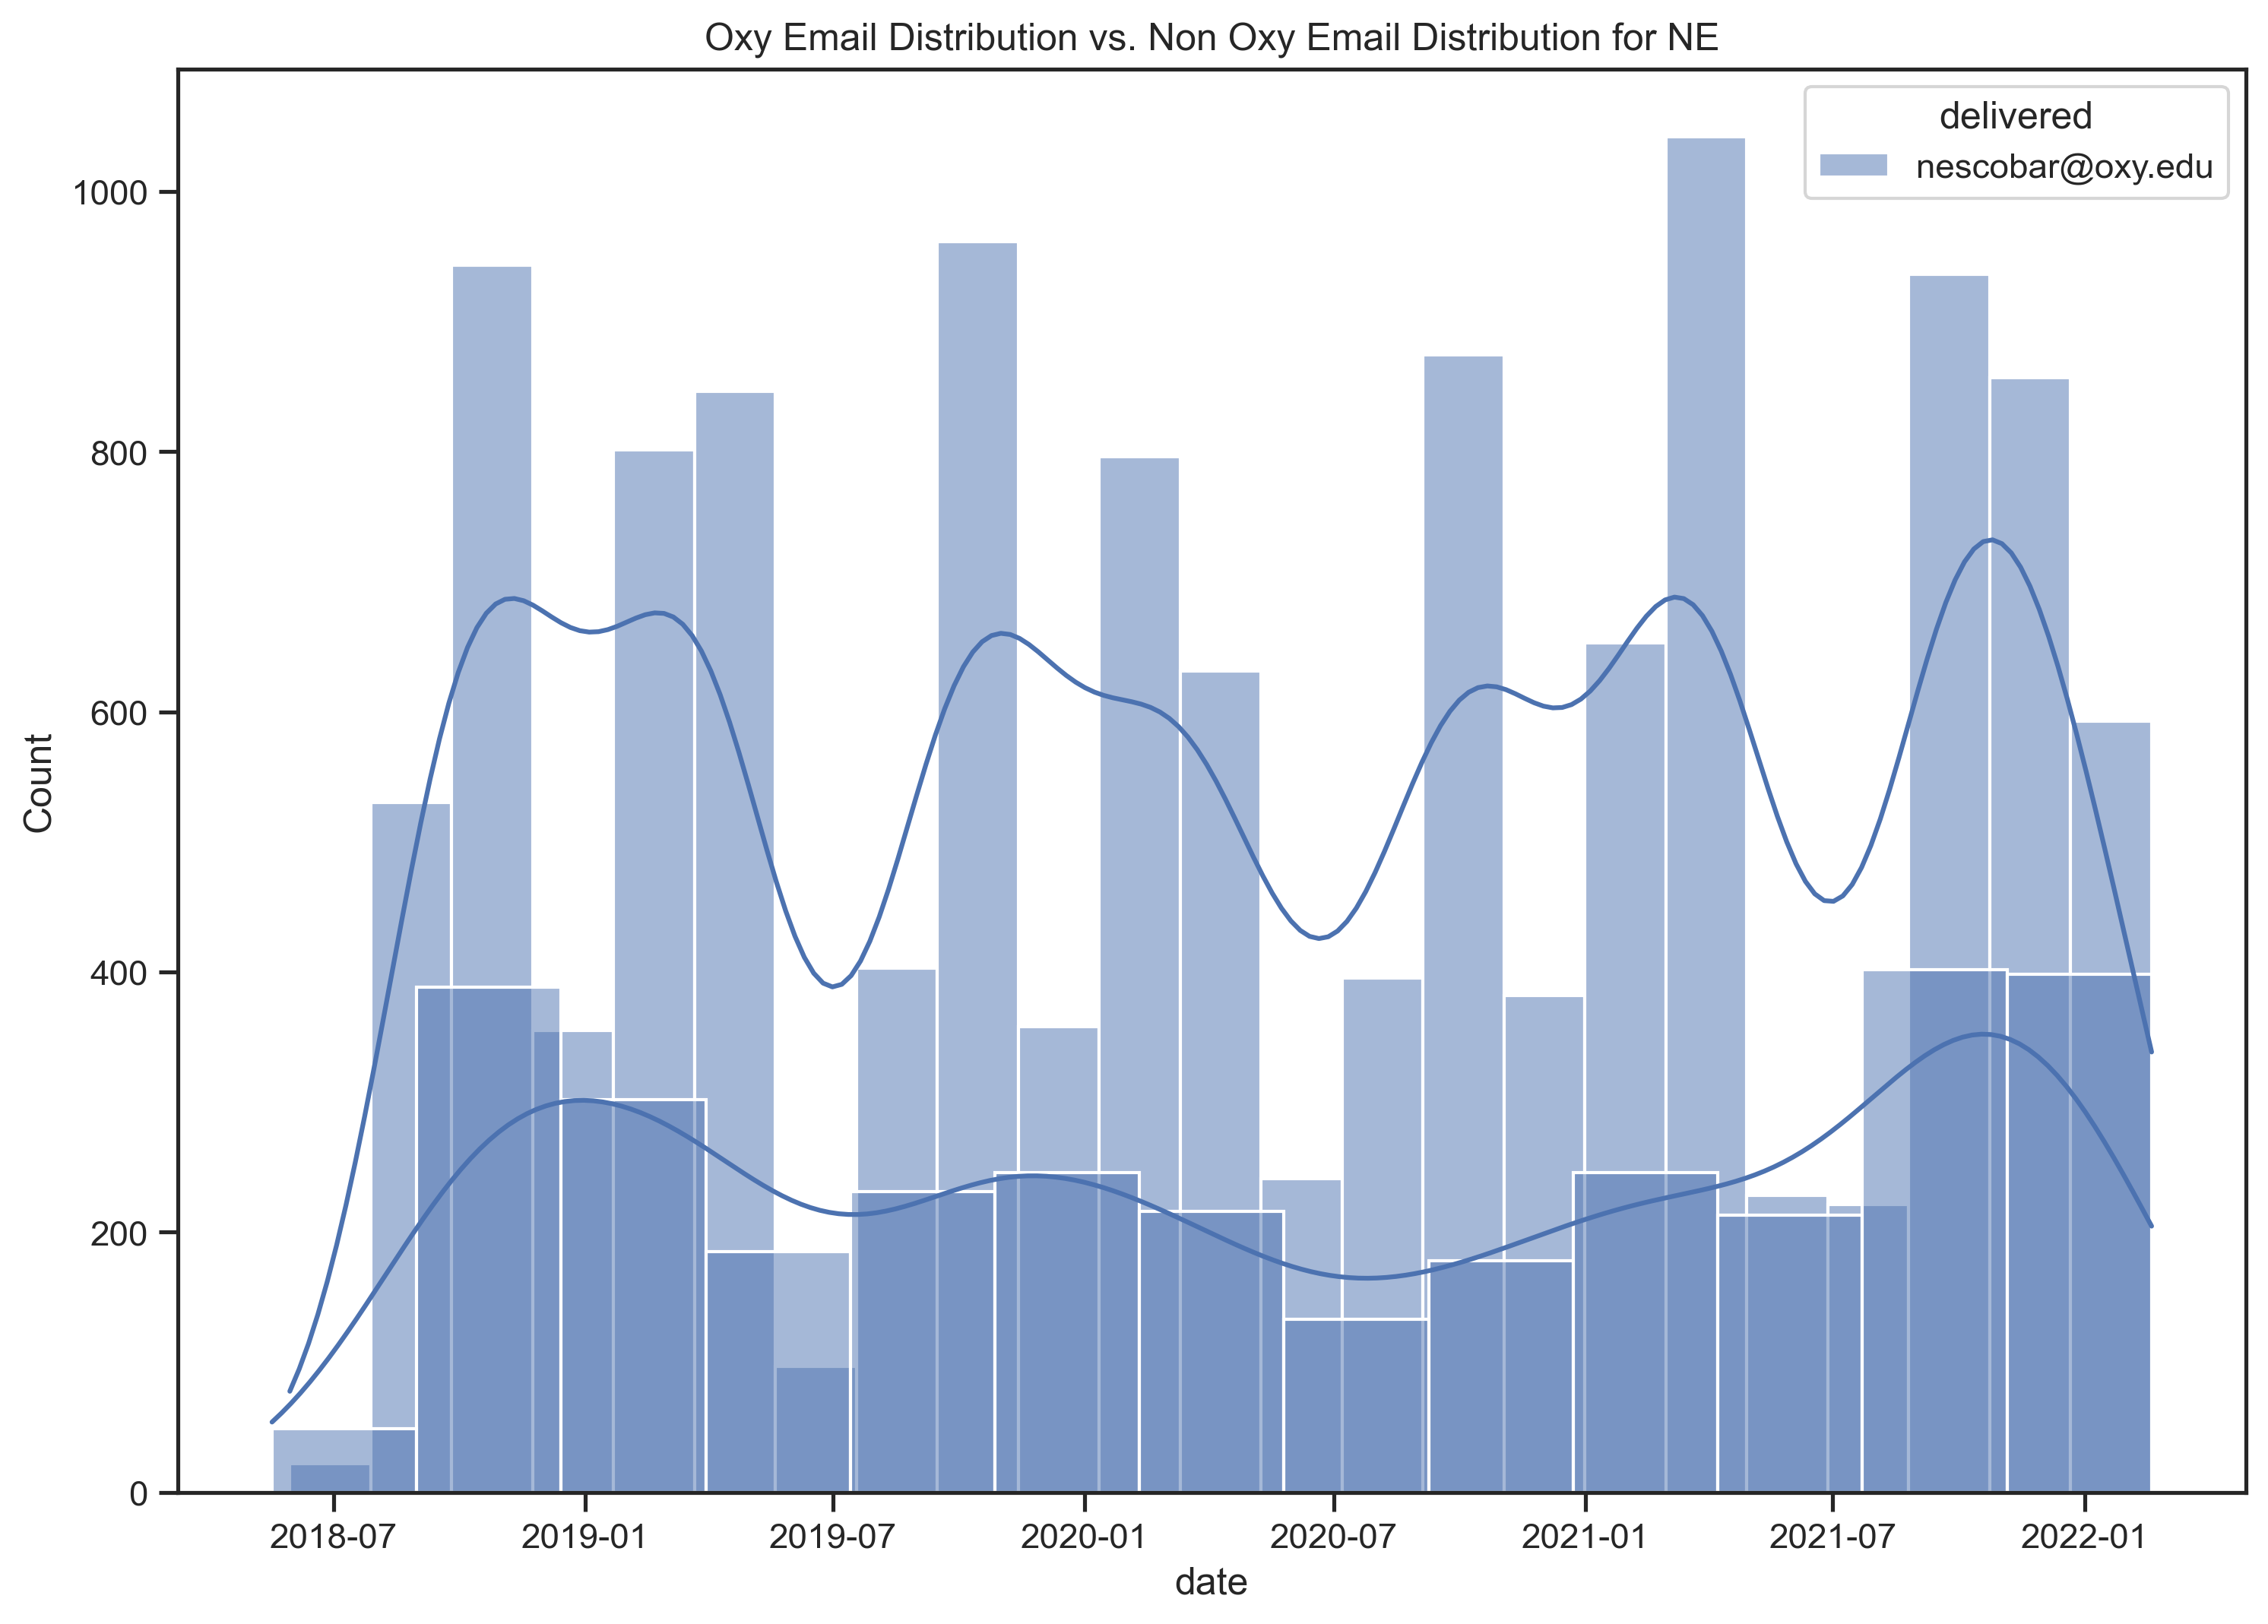

In [14]:
sns.histplot(data=oxy,x="date", hue = 'delivered', kde=True)
sns.histplot(data=nonOxy,x="date", hue = 'delivered', kde=True).set(title = 'Oxy Email Distribution vs. Non Oxy Email Distribution for NE')
plt.show()

We can start to see here how Oxy (the back plot) and non-Oxy (the front plot) email distribution compares. A much more consistent distribution, but we're still getting a little bit of the dipping, so we'll also look at the top couple of addresses to make sure we're not missing any Oxy emails that may have come through under another domain.

In [15]:
print("Non-Oxy Email Addresses")
display(nonOxy['from'].value_counts()[:20])

Non-Oxy Email Addresses


news@app.postmates.com                       358
audubonconnect@audubon.org                   355
handshake@mail.joinhandshake.com             327
info@switchboardhq.com                       161
microcenter@microcenterinsider.com           150
handshake@g.joinhandshake.com                129
no-reply+616d98fd@classroom.google.com        95
email@techsmith.messages4.com                 72
handshake@notifications.joinhandshake.com     65
offers@e.myunidays.com                        64
no-reply@customers.instacartemail.com         57
ncwarden@gmail.com                            55
OxyParcelDelivery@oxy.sclintra.com            51
discover@airbnb.com                           49
drive-shares-noreply@google.com               49
noreply@fortispay.com                         48
OxyParcelDelivery@sclintra.com                45
offers@m.myunidays.com                        44
drive@email.zipcar.com                        39
feedback@slack.com                            35
Name: from, dtype: i

And here we can see things like Handshake, Google Classroom and the Post Office still came through, as well as emails from a Oxy faculty with personal email addresses, so let's adjust our parameters and shuffle some messages around.

In [16]:
nonOxy = ne.loc[((~ne['from'].str.contains('oxy')) & (~ne['from'].str.contains('Oxy')) & (~ne['from'].str.contains('handshake')) & (~ne['from'].str.contains('ncwarden')) & (~ne['from'].str.contains('classroom')) & (~ne['from'].str.contains('erezlife')) & (~ne['from'].str.contains('justinnhli')))]
oxy = ne.loc[((ne['from'].str.contains('oxy')) | (ne['from'].str.contains('Oxy')) | (ne['from'].str.contains('handshake')) | (ne['from'].str.contains('ncwarden')) | (ne['from'].str.contains('classroom')) | (ne['from'].str.contains('erezlife')) | (ne['from'].str.contains('justinnhli')))]

sns.histplot(data=oxy,x="date", hue = 'delivered', kde=True)
sns.histplot(data=nonOxy,x="date", hue = 'delivered', kde=True).set(title = 'Oxy Email Distribution vs. Non Oxy Email Distribution for NE')
plt.show()

Tada! We have our expected distribution! Our non-Oxy messages form a nice even distribution over time, exactly what we were expecting to see. Similarly, we're going to grab the addresses for my main address, `GD` and take a look at the more interesting ones.

In [17]:
display(messages['from'].value_counts()[:20])

noreply@youtube.com                   3261
hello@email.touchofmodern.com         2113
nytdirect@nytimes.com                 1688
contact@mailer.humblebundle.com       1626
info@i.drop.com                       1598
nordstrom@eml.nordstrom.com           1447
ebay@reply.ebay.com                   1353
pacsunonline@m.pacsun.com             1230
microcenter@microcenterinsider.com    1166
express@em.express.com                1147
noreply@xmail.square-enix.com         1100
info@i.massdrop.com                   1087
email@e.redbubble.com                 1029
noreply@redditmail.com                 955
BestBuyInfo@emailinfo.bestbuy.com      901
dsw@em.dsw.com                         869
news@app.postmates.com                 710
Promo@promo.newegg.com                 696
noreply@stockx.com                     666
news@store.greenmangaming.com          627
Name: from, dtype: int64

In [18]:
fromMes = messages.loc[((messages['from'].str.contains("noreply@youtube.com")) |
                  (messages['from'].str.contains('nytdirect@nytimes.com')) |
                        (messages['from'].str.contains('info@i.drop.com')) |
                        (messages['from'].str.contains('nordstrom@eml.nordstrom.com')) |
                        (messages['from'].str.contains('ebay@reply.ebay.com')))]

sns.displot(data=fromMes,x="date", hue = 'from', kind = 'kde', height = 5, aspect = 3).set(title = 'Distribution of top sending addresses over time')

Here we can see a number of addresses, pulled out and highlighted over time. My favorite of all of these (and by favorite I mean the one that makes me gag a little) is Drop.com. Drop is an online marketplace that sens hobbyist and enthusiast gear. During the pandemic, they grew pretty big and expanded a lot. At the same time, we see on the distribution plot that during the height of people's panic about the pandemic, early-late 2020, they significantly increased their marketing. During a time when millions of people were struggling to afford to live and many were being laid off and prioritizing necessities, Drop ramps up advertising and marketing and push their products as hard as ever. It leaves a bad taste in the mouth. At the same time, we see sites like eBay reduce the number of marketing emails they send, as you can see in its dip, and stores like Nordstrom completely drop their email marketing campaigns encouraging people to spend money they don't have. The New York Times and Youtube, who have both done an enormous amount of coverage on the pandemic, starts sending out more newsletters as the pandemic crests. An interesting comparison of corporate priorities during a crisis.

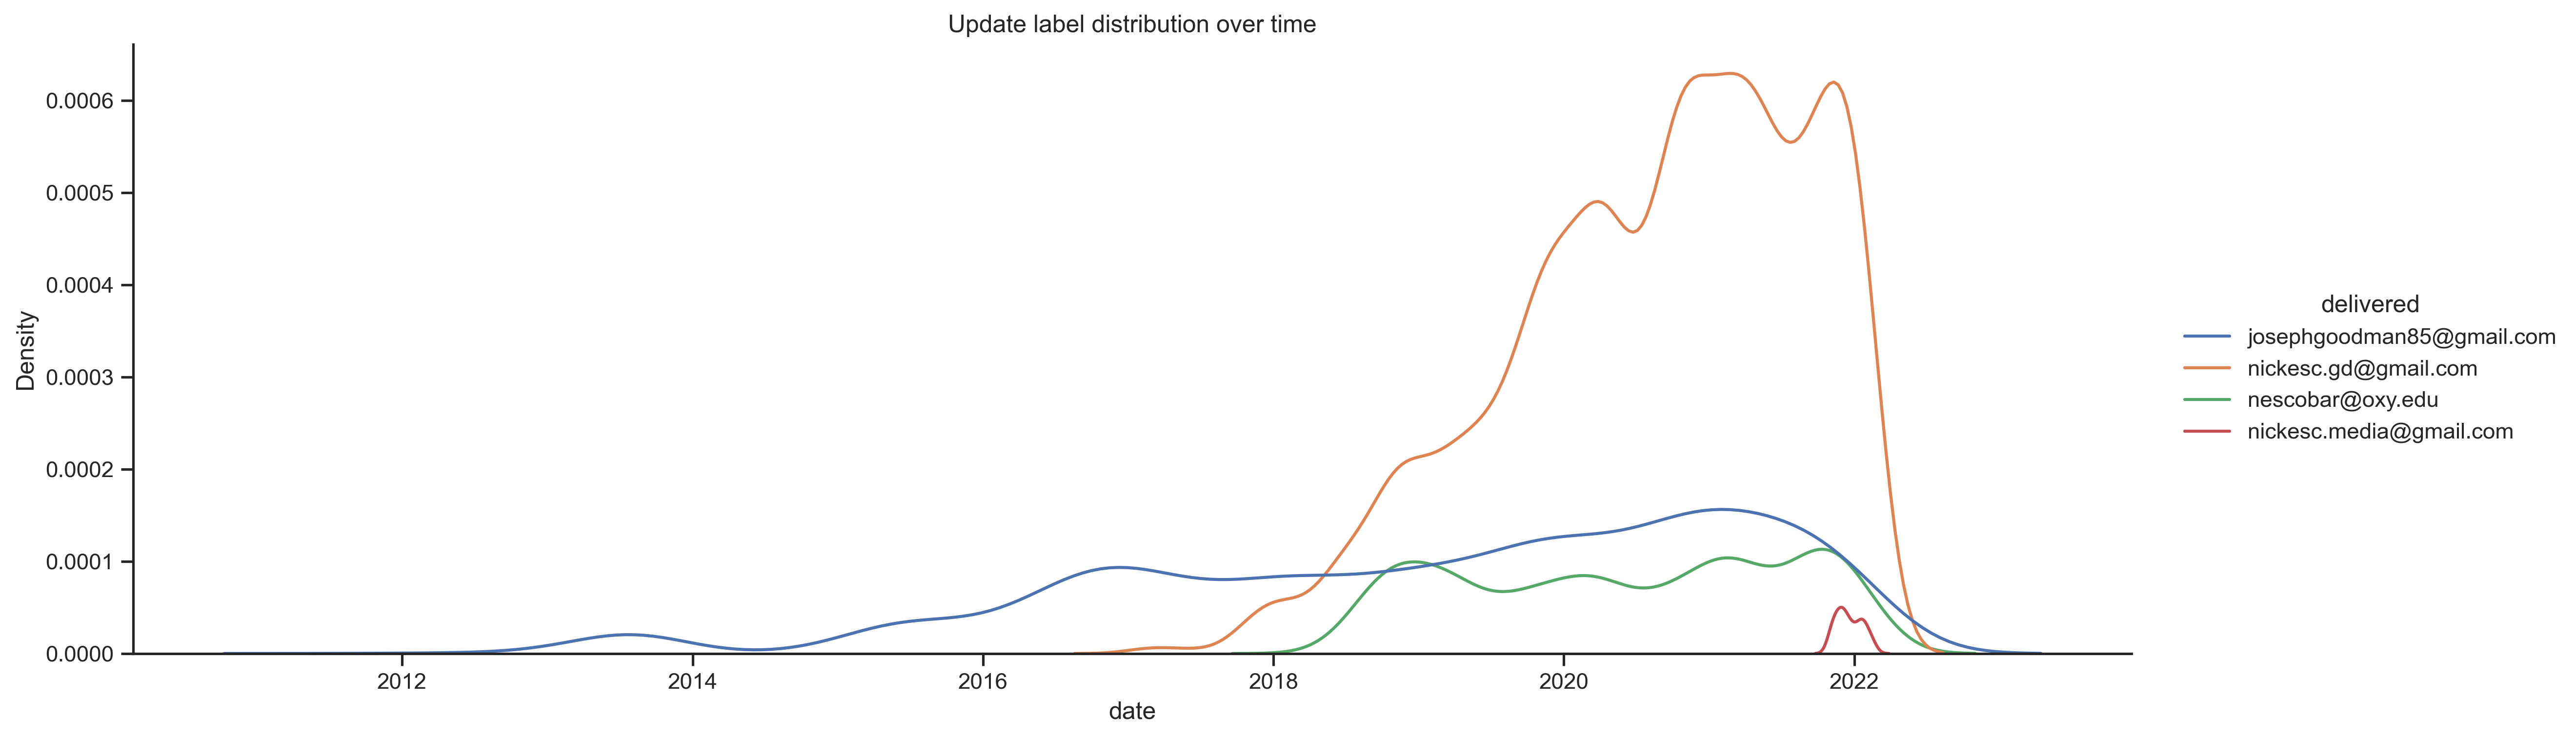

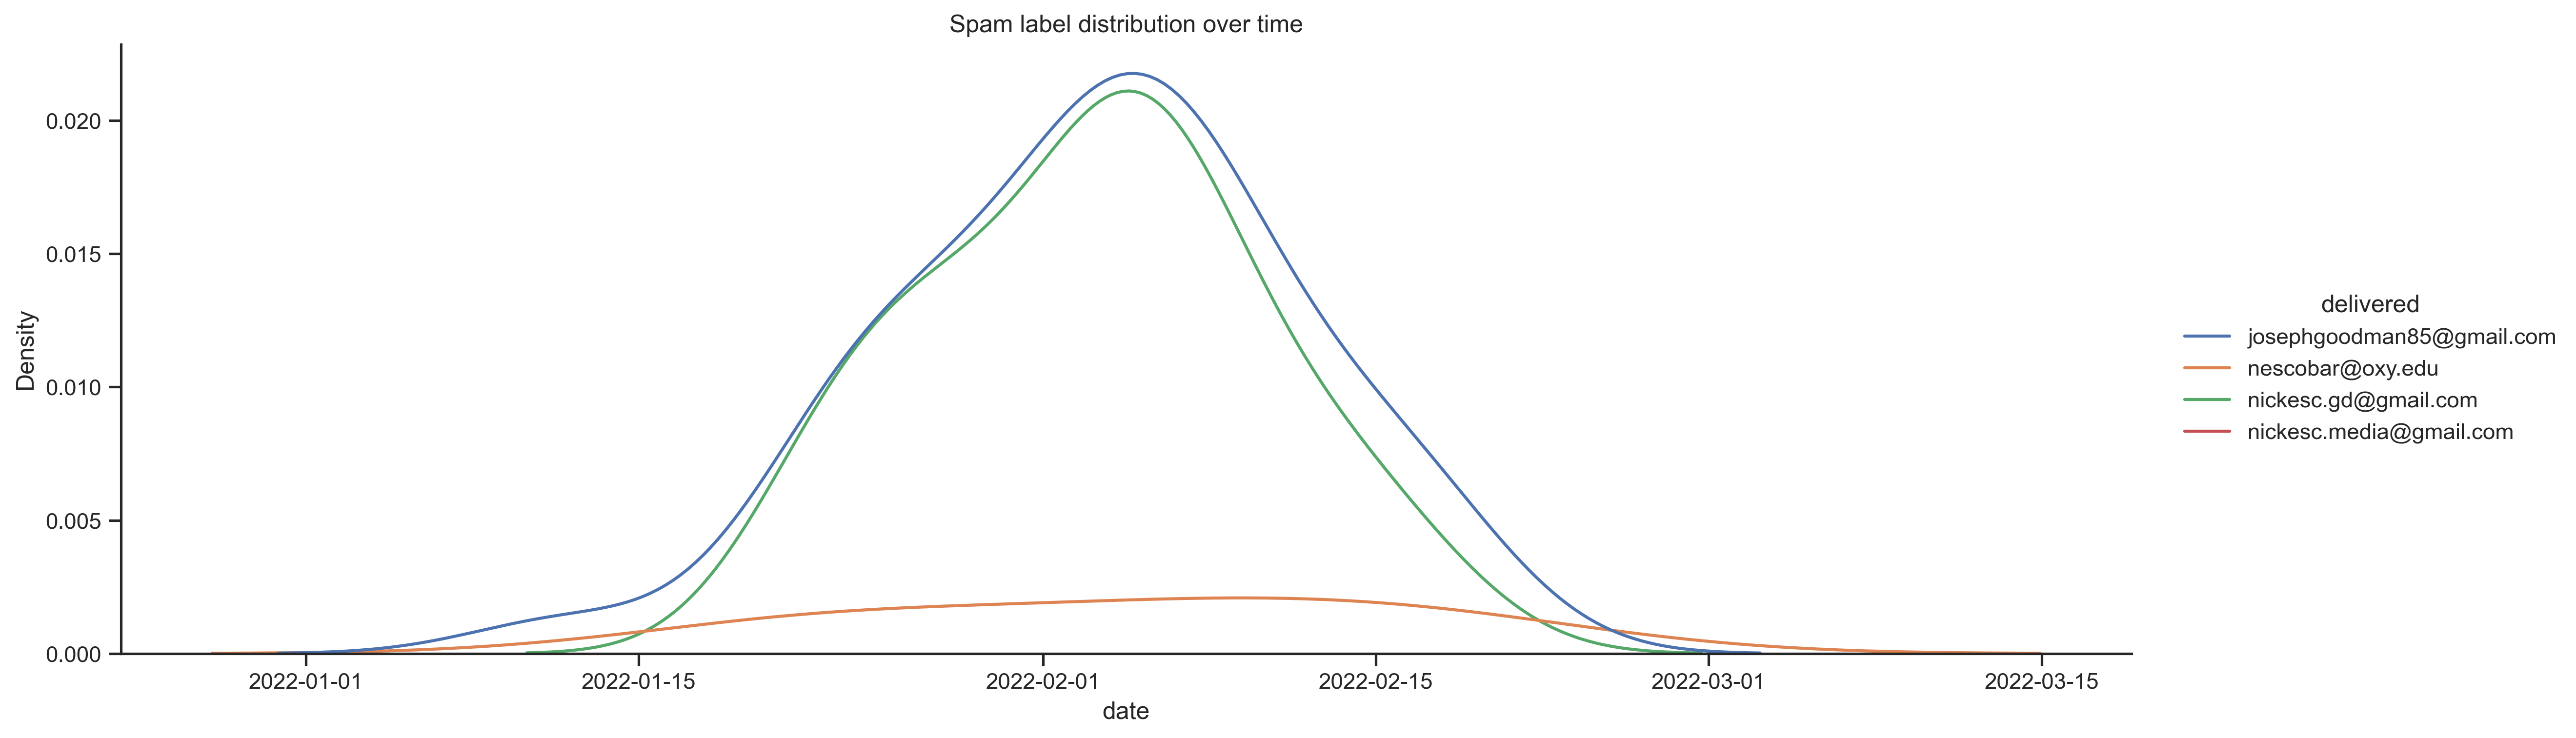

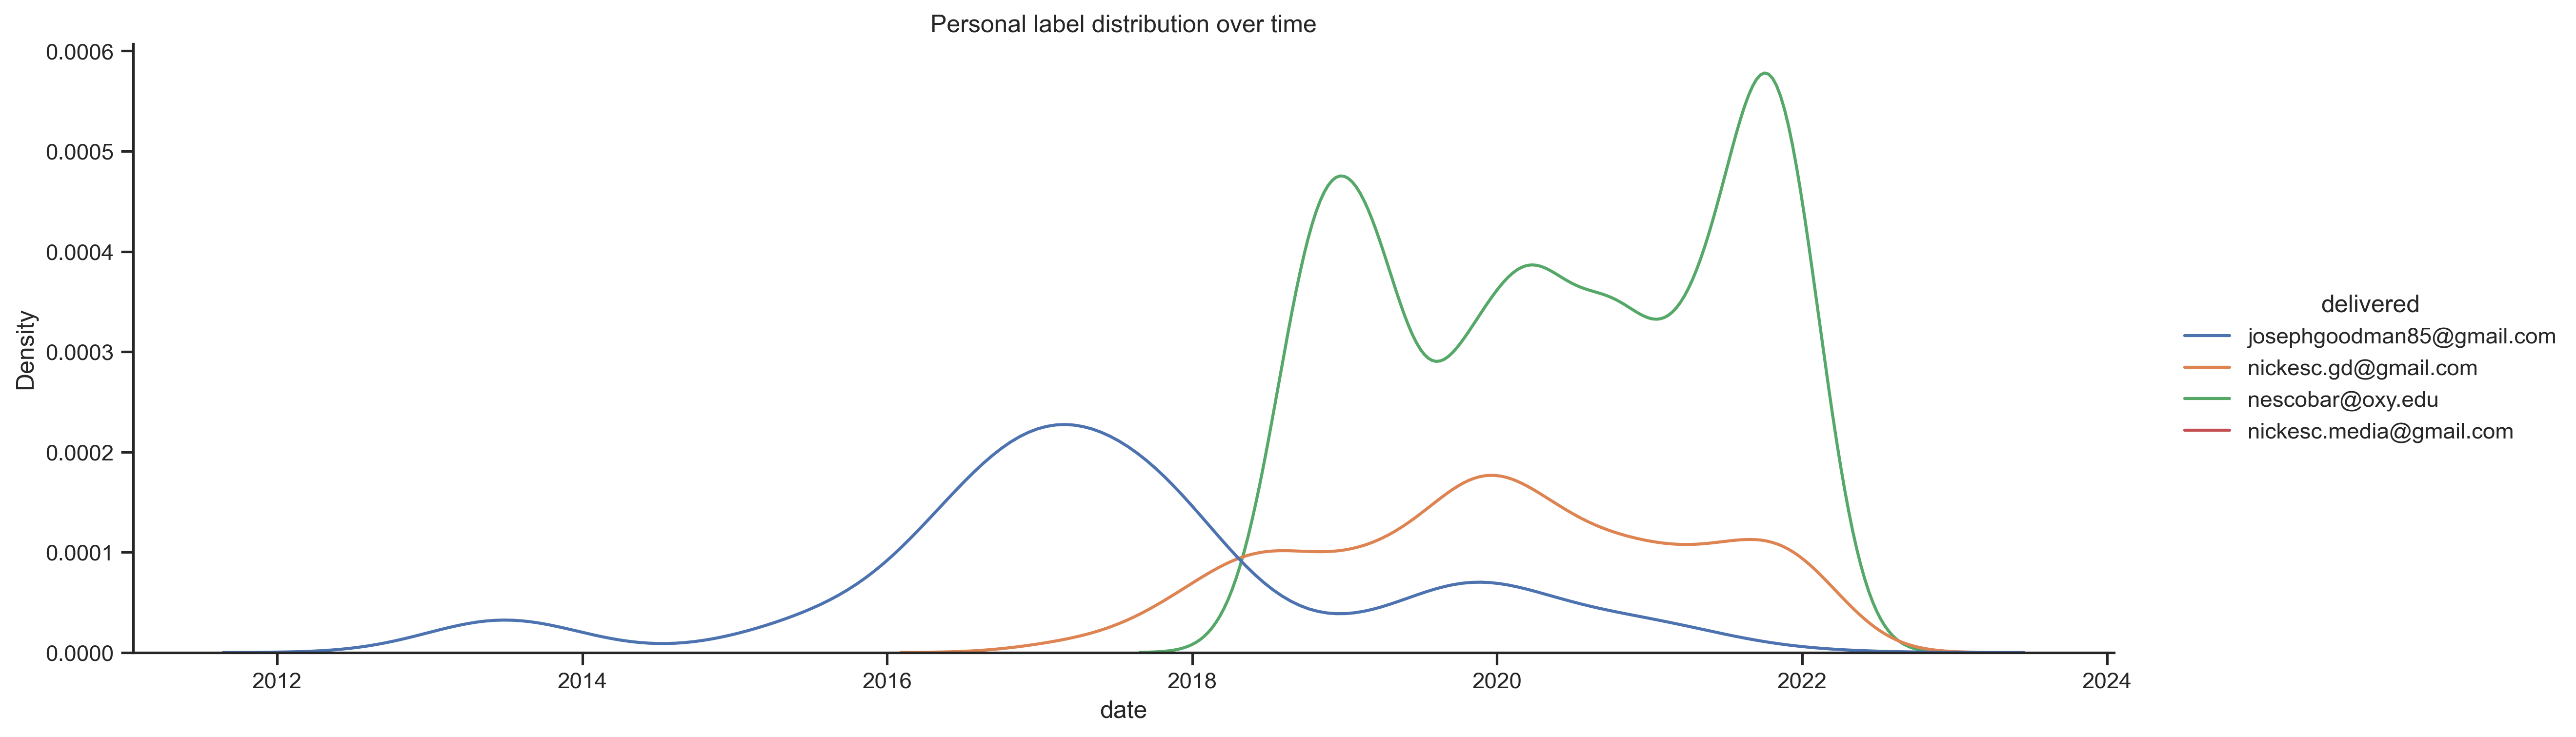

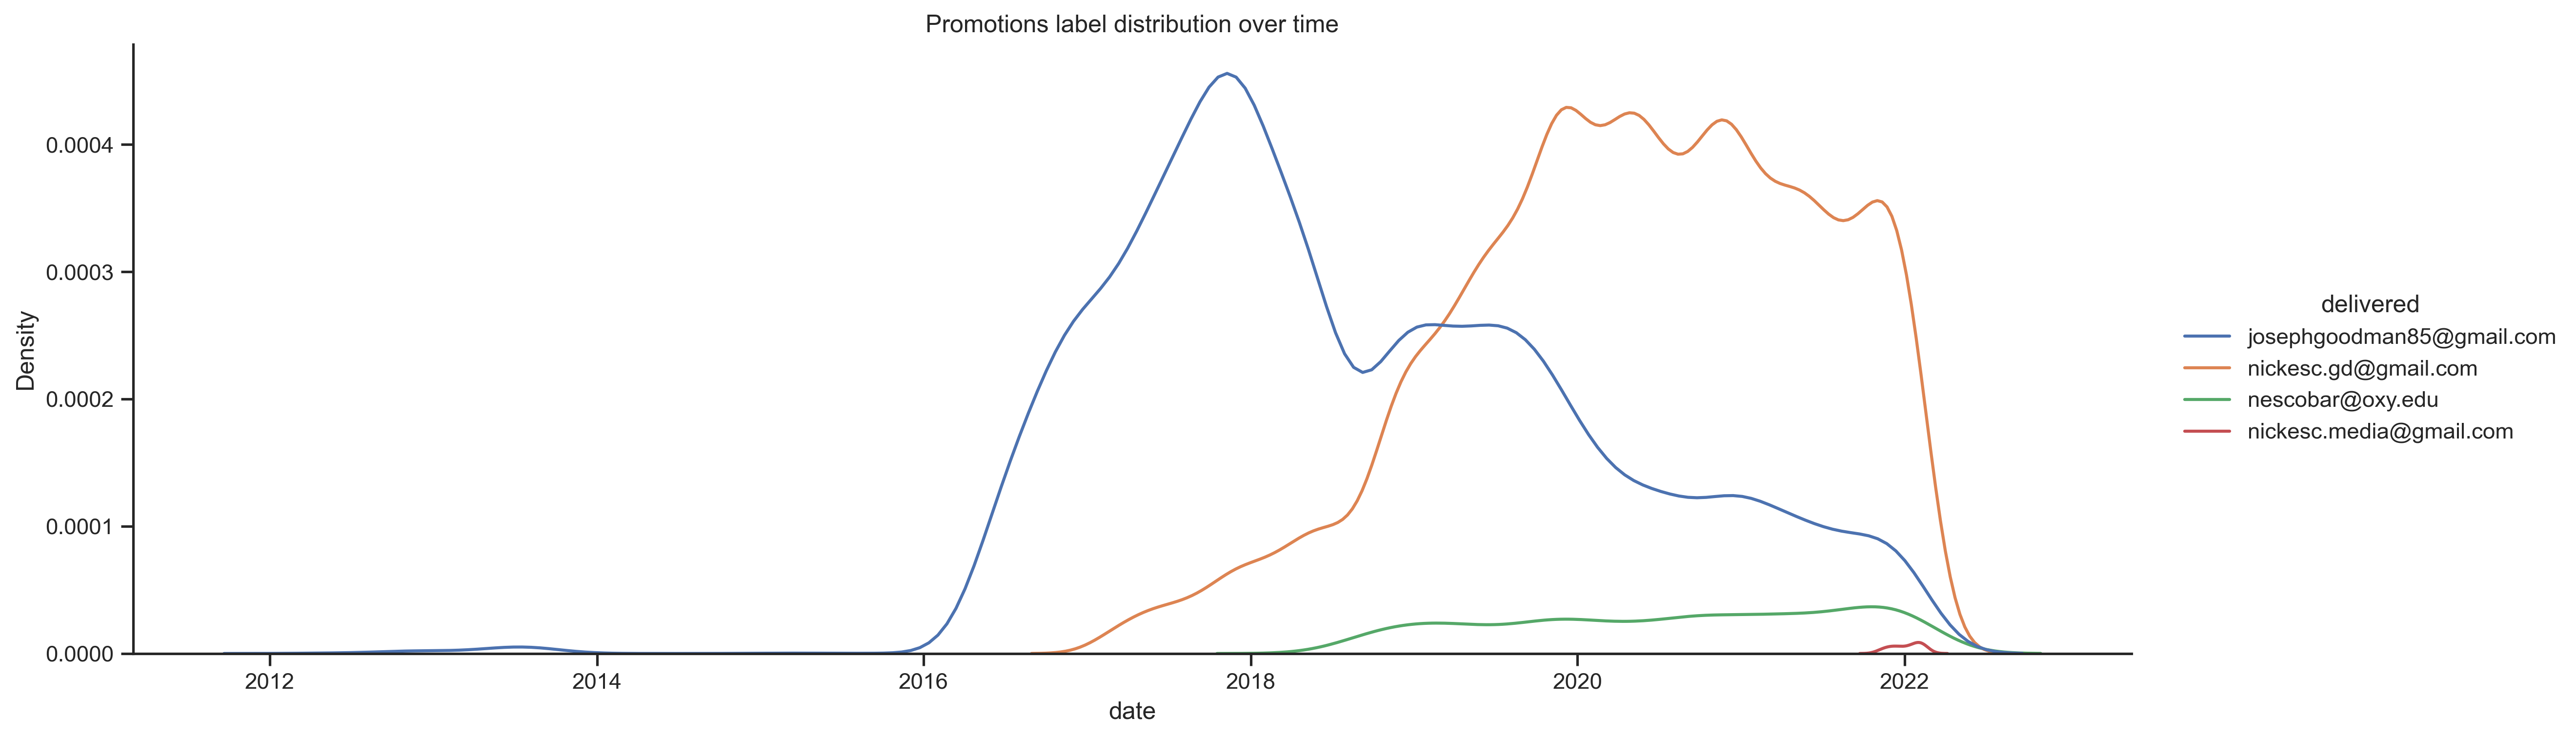

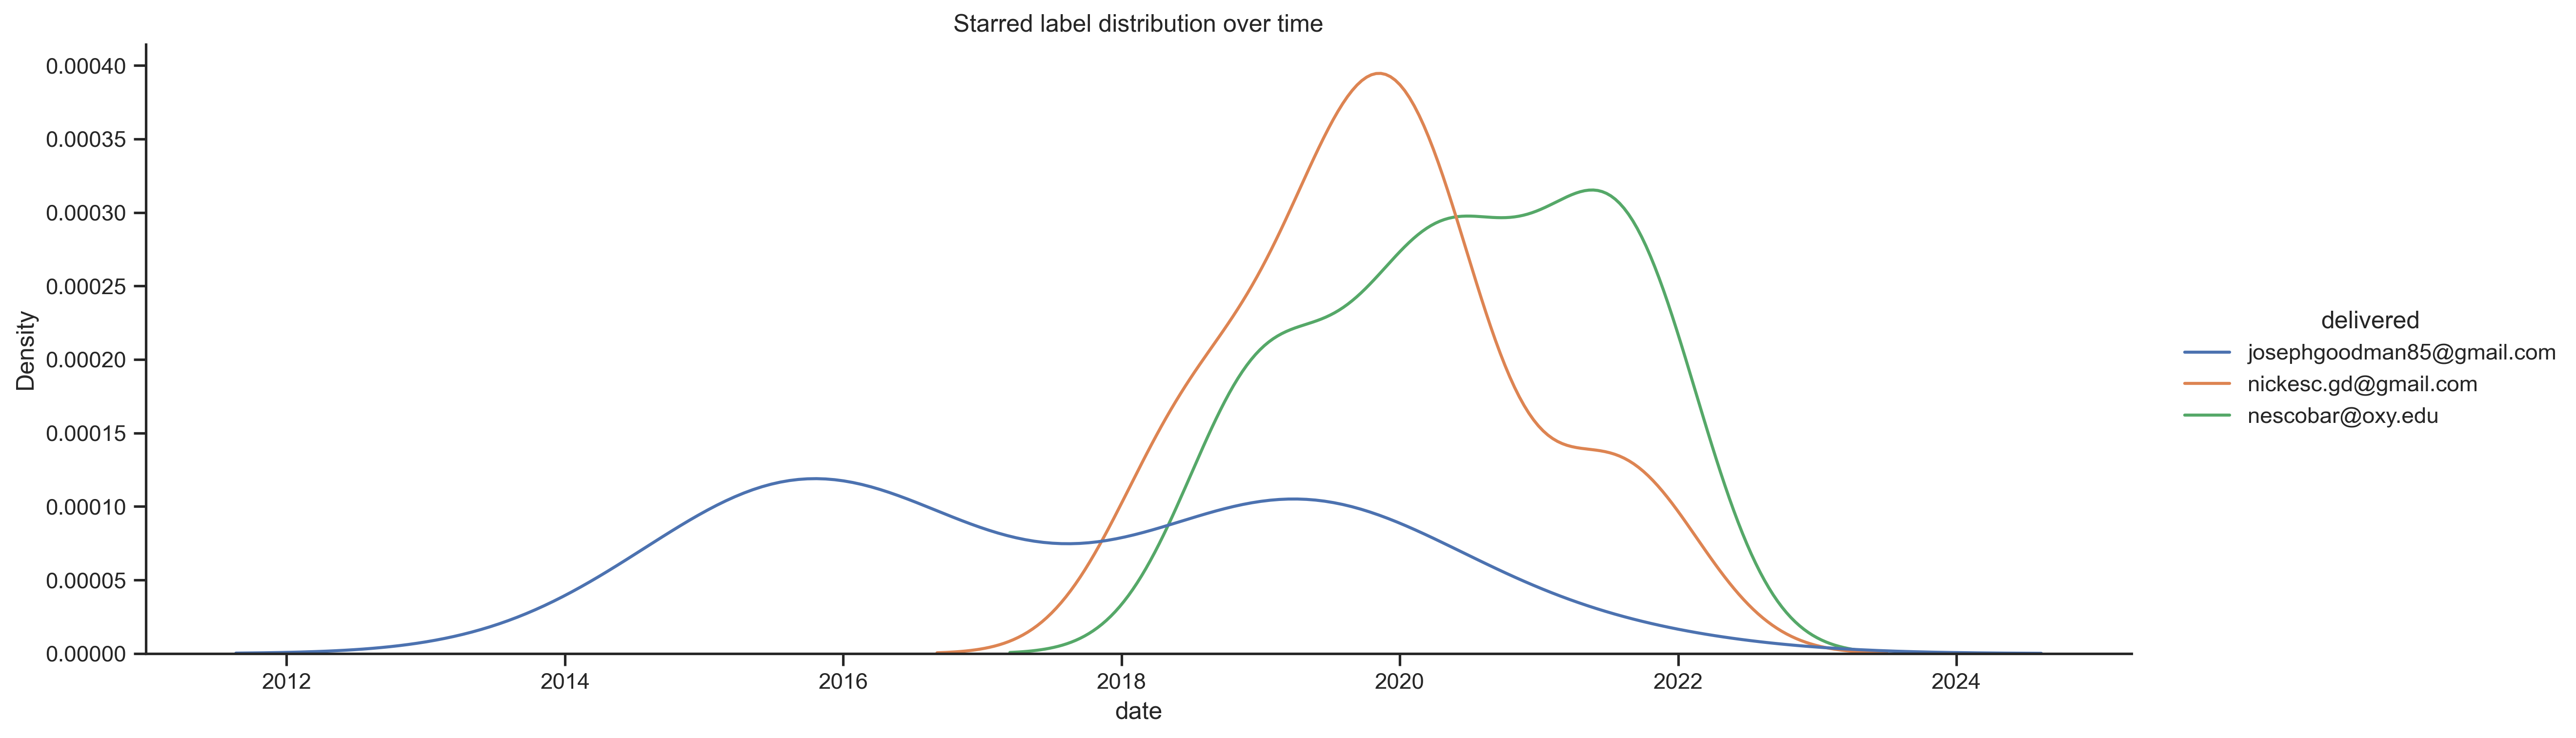

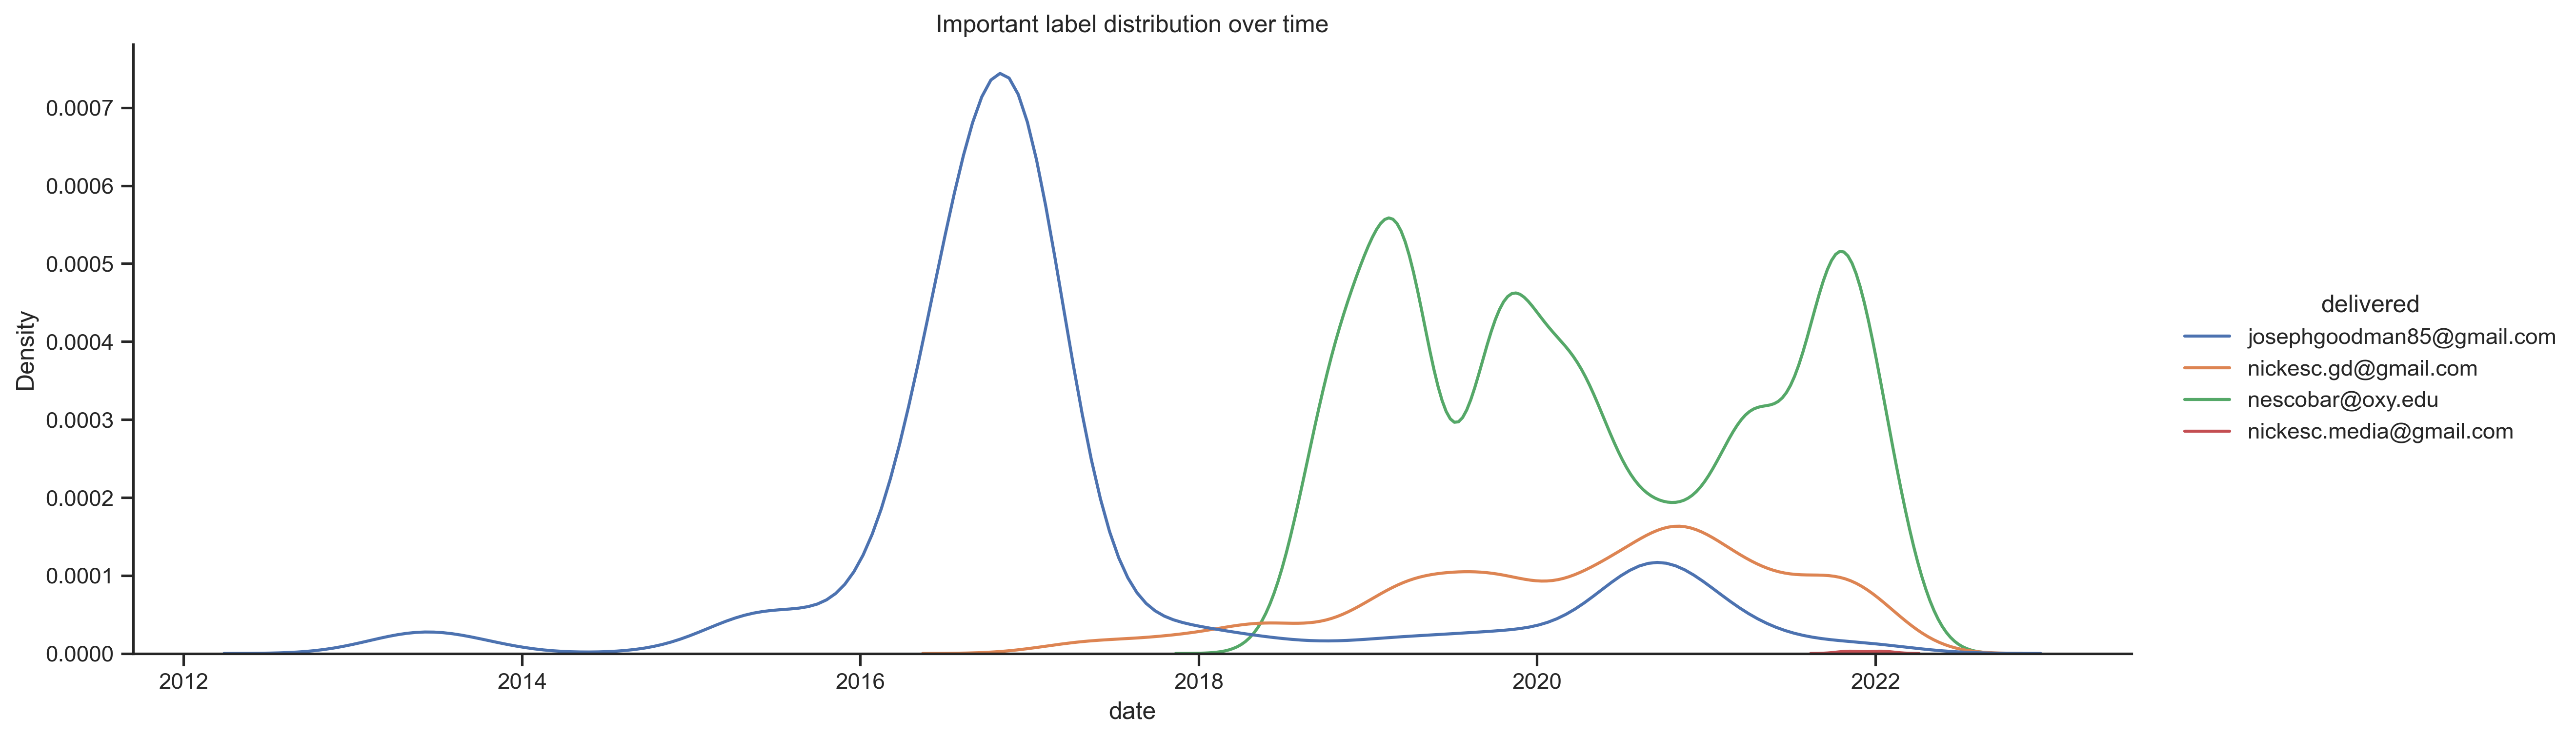

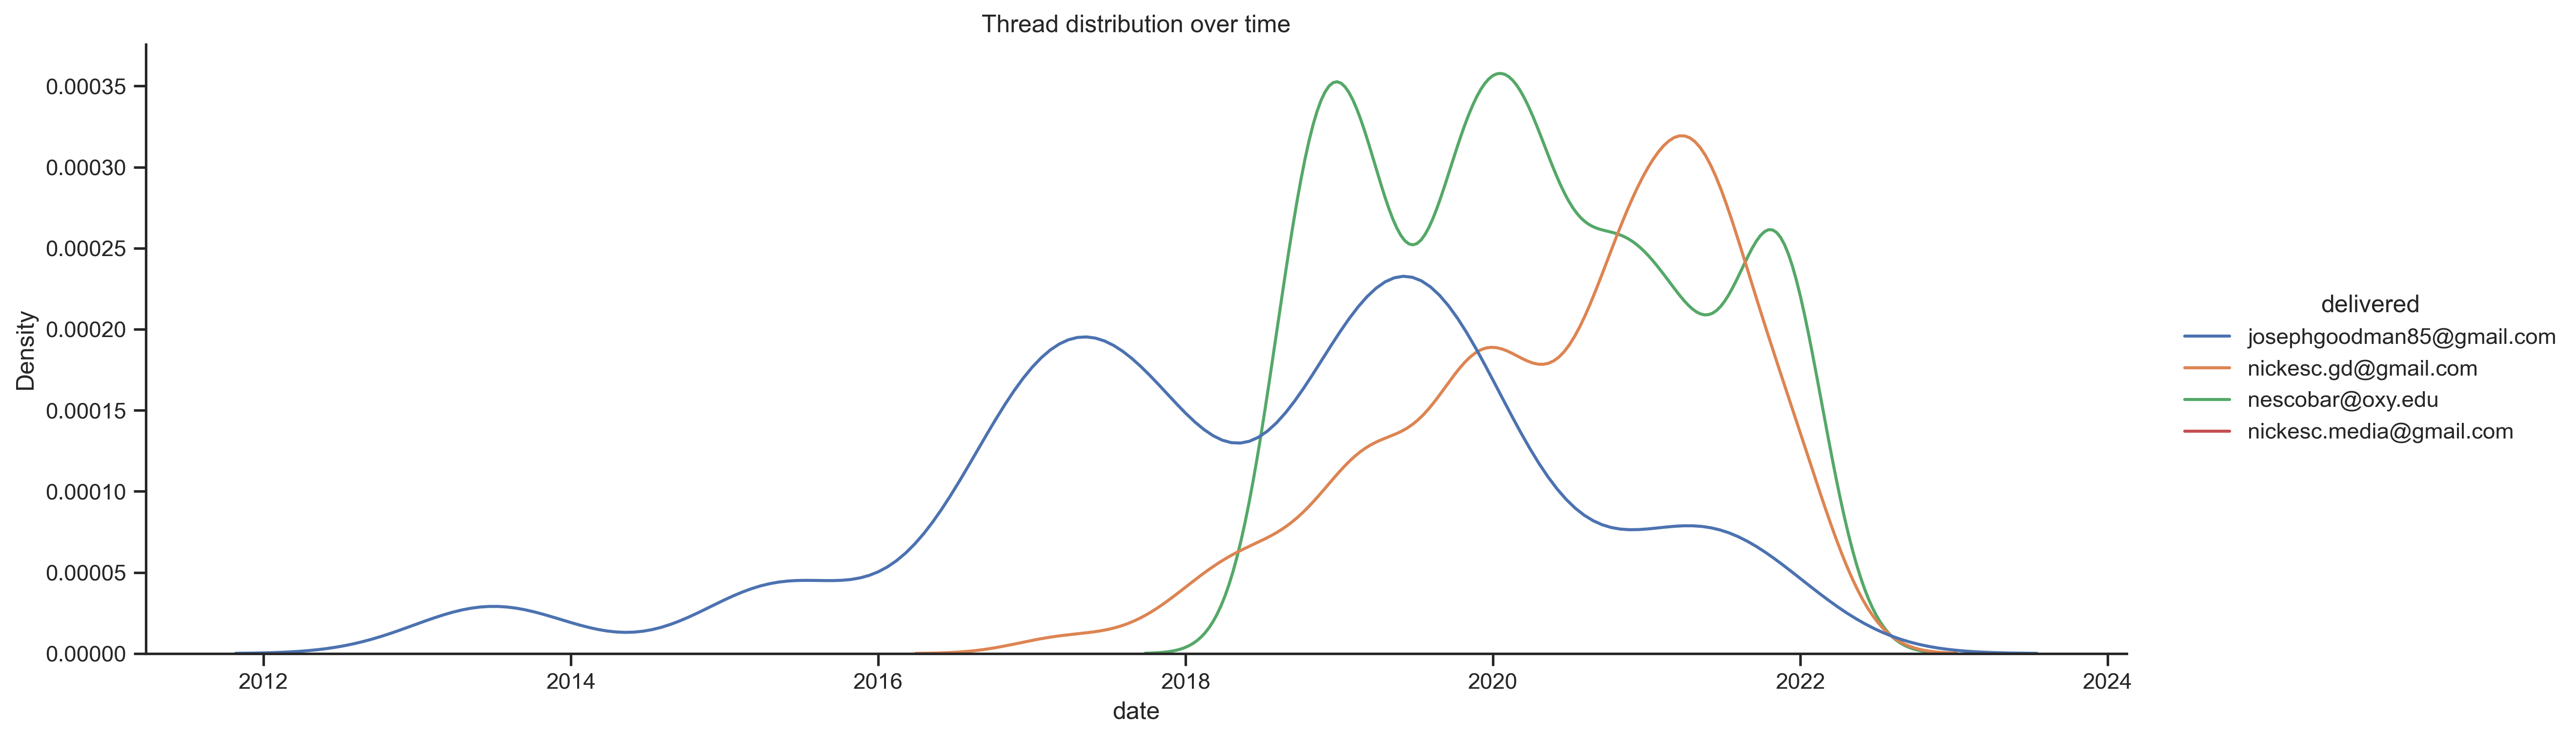

In [19]:
updates = messages[messages['updates'] == True]
sns.displot(data=updates,x="date", hue = 'delivered', kind = 'kde', height = 5, aspect = 3, warn_singular=False).set(title = 'Update label distribution over time')
spam = messages[messages['spam'] == True]
sns.displot(data=spam,x="date", hue = 'delivered', kind = 'kde', height = 5, aspect = 3, warn_singular=False).set(title = 'Spam label distribution over time')
personal  = messages[messages['personal'] == True]
sns.displot(data=personal,x="date", hue = 'delivered', kind = 'kde', height = 5, aspect = 3, warn_singular=False).set(title = 'Personal label distribution over time')
promotions = messages[messages['promotions'] == True]
sns.displot(data=promotions,x="date", hue = 'delivered', kind = 'kde', height = 5, aspect = 3).set(title = 'Promotions label distribution over time')
social = messages[messages['social'] == True]
sns.displot(data=social,x="date", hue = 'delivered', kind = 'kde', height = 5, aspect = 3).set(title = 'Social label distribution over time')
forums = messages[messages['forums'] == True]
sns.displot(data=forums,x="date", hue = 'delivered', kind = 'kde', height = 5, aspect = 3).set(title = 'Forums label distribution over time')
starred = messages[messages['starred'] == True]
sns.displot(data=starred,x="date", hue = 'delivered', kind = 'kde', height = 5, aspect = 3).set(title = 'Starred label distribution over time')
important = messages[messages['important'] == True]
sns.displot(data=important,x="date", hue = 'delivered', kind = 'kde', height = 5, aspect = 3).set(title = 'Important label distribution over time')
thread = messages[messages['thread'] == True]
sns.displot(data=thread,x="date", hue = 'delivered', kind = 'kde', height = 5, aspect = 3, warn_singular=False).set(title = 'Thread distribution over time')

Finally, I want to spend a short amount of time looking at the label distribution. We could say a lot about them, but I want to keep it brief, they're pretty and speak for themselves in a lot of ways I think. The most interesting of these though, I think, is the spam plot. The spam plot only shows data from 2022. To me, this either means the spam label wasn't created until then, or more likely I think, the spam gets deleted every so often, which would also explain the shape of the graph. It's also intersting to see where the different accounts differ significantly in the types of emails they get, like how `NE` receives almost all the Forum, Personal, and Important emails, which makes sense given it's my school email. You can also see, in many of these, the drop off that came from the switch away from `JG`, and other accounts picking up the slack.

## Conclusion

All in all, I'm happy with where we've found ourselves. We've taken a good, hard look at the history of my inbox, visualizing different trends and anomalies to get a clearer idea of what happened, how we got there, and the effects afterwards. It also gave a clearer idea of what is actually in my inbox and who sends me emails. I've examined the ways that some individual companies have acted during the pandemic in regards to emails, trying to understand better how companies use marketing differently at different times to achieve different results.

My inbox provided a lot of information -- and though I think that I'm ready to put this project behind me for now, I do want to come back to it in the future, do the same collections and see what new insights I can come up with years from now.